# Sephora Reviews Sentiment Analysis

This notebook performs sentiment analysis on 1M Sephora product reviews using a pre-trained transformer model (DistilBERT).

## Pipeline Overview:
1. Load and combine 5 CSV files containing reviews
2. Clean review text (remove HTML, special characters, normalize)
3. Apply sentiment analysis using DistilBERT
4. Process in batches to handle memory efficiently
5. Save processed data with sentiment scores

## Cell 1: Imports and Setup

In [2]:
# Standard library imports
import os
import re
import warnings
from pathlib import Path
from typing import List, Dict, Tuple

# Data manipulation
import pandas as pd
import numpy as np

# Progress tracking
from tqdm.auto import tqdm

# HTML parsing
from html import unescape

# Sentiment analysis with transformers
try:
    from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
    import torch
    print("✓ Transformers library loaded successfully")
except ImportError:
    print("⚠ Installing required libraries: transformers, torch...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'transformers', 'torch', 'pyarrow', 'fastparquet'])
    from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
    import torch
    print("✓ Libraries installed and loaded")

# Configure environment
warnings.filterwarnings('ignore')
tqdm.pandas()

# Set device (GPU if available, else CPU)
device = 0 if torch.cuda.is_available() else -1
device_name = "GPU" if device == 0 else "CPU"
print(f"✓ Using device: {device_name}")

# Define paths
DATA_DIR = Path("/Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/data")
PROCESSED_DIR = DATA_DIR / "processed"
OUTPUT_FILE = PROCESSED_DIR / "reviews_with_sentiment.parquet"

# Review file names
REVIEW_FILES = [
    "reviews_0-250.csv",
    "reviews_250-500.csv",
    "reviews_500-750.csv",
    "reviews_750-1250.csv",
    "reviews_1250-end.csv"
]

# Configuration
BATCH_SIZE = 32
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"
MAX_LENGTH = 512  # Maximum token length for DistilBERT

print(f"✓ Configuration complete")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Model: {MODEL_NAME}")
print(f"  - Output: {OUTPUT_FILE}")

⚠ Installing required libraries: transformers, torch...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 45.4 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 25.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 56.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 65.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 MB 72.1 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 74.4 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.0/687.0 kB 27.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 77.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 24.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 [transformers] [transformers]ub]
✓ Libraries installed and loaded
✓ Using device: CPU
✓ Configurati

## Cell 2: Load and Combine All Review Files

In [3]:
def load_review_files(data_dir: Path, file_names: List[str]) -> pd.DataFrame:
    """
    Load and combine multiple CSV files containing reviews.
    
    Args:
        data_dir: Directory containing the CSV files
        file_names: List of CSV file names to load
        
    Returns:
        Combined DataFrame with all reviews
    """
    dfs = []
    total_rows = 0
    
    print(f"Loading {len(file_names)} review files...")
    print("-" * 60)
    
    for file_name in file_names:
        file_path = data_dir / file_name
        
        try:
            # Load CSV with error handling
            df = pd.read_csv(file_path, low_memory=False)
            rows = len(df)
            total_rows += rows
            
            print(f"✓ {file_name:25s} - {rows:,} rows")
            dfs.append(df)
            
        except FileNotFoundError:
            print(f"✗ {file_name:25s} - FILE NOT FOUND")
        except Exception as e:
            print(f"✗ {file_name:25s} - ERROR: {str(e)}")
    
    print("-" * 60)
    
    if not dfs:
        raise ValueError("No files were successfully loaded!")
    
    # Combine all dataframes
    print(f"Combining {len(dfs)} dataframes...")
    combined_df = pd.concat(dfs, ignore_index=True)
    
    print(f"✓ Total reviews loaded: {len(combined_df):,}")
    print(f"✓ Memory usage: {combined_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    return combined_df


# Load all review files
try:
    df_reviews = load_review_files(DATA_DIR, REVIEW_FILES)
    
    # Display basic info
    print("\n" + "=" * 60)
    print("DATASET OVERVIEW")
    print("=" * 60)
    print(f"Shape: {df_reviews.shape}")
    print(f"\nColumns: {list(df_reviews.columns)}")
    print(f"\nFirst few rows:")
    display(df_reviews.head(3))
    
    # Check for review text column
    review_columns = [col for col in df_reviews.columns if 'review' in col.lower() or 'text' in col.lower() or 'comment' in col.lower()]
    print(f"\nPotential review text columns: {review_columns}")
    
except Exception as e:
    print(f"ERROR: Failed to load review files - {str(e)}")
    raise

Loading 5 review files...
------------------------------------------------------------
✓ reviews_0-250.csv         - 602,130 rows
✓ reviews_250-500.csv       - 206,725 rows
✓ reviews_500-750.csv       - 116,262 rows
✓ reviews_750-1250.csv      - 119,317 rows
✓ reviews_1250-end.csv      - 49,977 rows
------------------------------------------------------------
Combining 5 dataframes...
✓ Total reviews loaded: 1,094,411
✓ Memory usage: 1417.79 MB

DATASET OVERVIEW
Shape: (1094411, 19)

Columns: ['Unnamed: 0', 'author_id', 'rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name', 'brand_name', 'price_usd']

First few rows:


,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0



Potential review text columns: ['review_text', 'review_title']


## Cell 3: Text Cleaning Function

In [4]:
def clean_review_text(text: str) -> str:
    """
    Clean review text by removing HTML, special characters, and normalizing whitespace.
    
    Args:
        text: Raw review text
        
    Returns:
        Cleaned review text
    """
    # Handle missing values
    if pd.isna(text) or text is None:
        return ""
    
    # Convert to string
    text = str(text)
    
    # Decode HTML entities (e.g., &amp; -> &, &lt; -> <)
    text = unescape(text)
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', ' ', text)
    
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\!\?\'\-]', ' ', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text


def prepare_reviews_for_sentiment(df: pd.DataFrame, text_column: str) -> pd.DataFrame:
    """
    Prepare reviews dataframe for sentiment analysis.
    
    Args:
        df: Reviews dataframe
        text_column: Name of the column containing review text
        
    Returns:
        DataFrame with cleaned text and valid reviews
    """
    print(f"Preparing reviews for sentiment analysis...")
    print(f"Initial review count: {len(df):,}")
    
    # Create a copy to avoid modifying original
    df_clean = df.copy()
    
    # Clean the review text
    print(f"Cleaning text in column '{text_column}'...")
    df_clean['cleaned_text'] = df_clean[text_column].progress_apply(clean_review_text)
    
    # Filter out empty reviews
    initial_count = len(df_clean)
    df_clean = df_clean[df_clean['cleaned_text'].str.len() > 0].copy()
    removed = initial_count - len(df_clean)
    
    print(f"✓ Removed {removed:,} empty reviews")
    print(f"✓ Final review count: {len(df_clean):,}")
    
    # Calculate text length statistics
    df_clean['text_length'] = df_clean['cleaned_text'].str.len()
    
    print(f"\nText length statistics:")
    print(f"  - Mean: {df_clean['text_length'].mean():.0f} characters")
    print(f"  - Median: {df_clean['text_length'].median():.0f} characters")
    print(f"  - Min: {df_clean['text_length'].min()} characters")
    print(f"  - Max: {df_clean['text_length'].max()} characters")
    
    # Show examples
    print(f"\n{'=' * 60}")
    print("EXAMPLE CLEANED REVIEWS")
    print("=" * 60)
    for idx, row in df_clean.head(3).iterrows():
        original = str(row[text_column])[:100]
        cleaned = row['cleaned_text'][:100]
        print(f"\nOriginal: {original}...")
        print(f"Cleaned:  {cleaned}...")
    
    return df_clean


# Detect review text column (adjust if needed)
# Common column names: 'review_text', 'text', 'review', 'comment', 'review_content'
possible_columns = ['review_text', 'text', 'review', 'comment', 'review_content', 'comments']
review_text_column = None

for col in possible_columns:
    if col in df_reviews.columns:
        review_text_column = col
        break

if review_text_column is None:
    print("⚠ Could not auto-detect review text column. Please specify manually:")
    print(f"Available columns: {list(df_reviews.columns)}")
    # Uncomment and set the correct column name:
    # review_text_column = "your_column_name_here"
else:
    print(f"✓ Detected review text column: '{review_text_column}'")
    
    # Clean and prepare reviews
    df_reviews_clean = prepare_reviews_for_sentiment(df_reviews, review_text_column)

✓ Detected review text column: 'review_text'
Preparing reviews for sentiment analysis...
Initial review count: 1,094,411
Cleaning text in column 'review_text'...


  0%|          | 0/1094411 [00:00<?, ?it/s]

✓ Removed 1,458 empty reviews
✓ Final review count: 1,092,953

Text length statistics:
  - Mean: 320 characters
  - Median: 262 characters
  - Min: 1 characters
  - Max: 6430 characters

EXAMPLE CLEANED REVIEWS

Original: I use this with the Nudestix “Citrus Clean Balm & Make-Up Melt“ to double cleanse and it has complet...
Cleaned:  I use this with the Nudestix Citrus Clean Balm Make-Up Melt to double cleanse and it has completely ...

Original: I bought this lip mask after reading the reviews and the hype. Unfortunately, it did not meet my exp...
Cleaned:  I bought this lip mask after reading the reviews and the hype. Unfortunately, it did not meet my exp...

Original: My review title says it all! I get so excited to get into bed and apply this lip mask. I do see a di...
Cleaned:  My review title says it all! I get so excited to get into bed and apply this lip mask. I do see a di...


## Cell 4: Sentiment Analysis Function with Batching

In [5]:
class SentimentAnalyzer:
    """
    Production-ready sentiment analyzer using DistilBERT.
    Handles batching, error handling, and memory management.
    """
    
    def __init__(self, model_name: str = MODEL_NAME, batch_size: int = BATCH_SIZE, device: int = -1):
        """
        Initialize the sentiment analyzer.
        
        Args:
            model_name: HuggingFace model name
            batch_size: Number of reviews to process at once
            device: -1 for CPU, 0 for GPU
        """
        self.model_name = model_name
        self.batch_size = batch_size
        self.device = device
        
        print(f"Initializing sentiment analyzer...")
        print(f"  - Model: {model_name}")
        print(f"  - Batch size: {batch_size}")
        print(f"  - Device: {'GPU' if device >= 0 else 'CPU'}")
        
        try:
            # Load the sentiment analysis pipeline
            self.pipeline = pipeline(
                "sentiment-analysis",
                model=model_name,
                device=device,
                truncation=True,
                max_length=MAX_LENGTH
            )
            print(f"✓ Model loaded successfully")
            
        except Exception as e:
            print(f"✗ Error loading model: {str(e)}")
            raise
    
    def analyze_batch(self, texts: List[str]) -> List[Dict]:
        """
        Analyze sentiment for a batch of texts.
        
        Args:
            texts: List of review texts
            
        Returns:
            List of dictionaries with sentiment results
        """
        try:
            # Filter out empty texts
            valid_texts = [text if text else " " for text in texts]
            
            # Run inference
            results = self.pipeline(valid_texts, batch_size=self.batch_size)
            
            return results
            
        except Exception as e:
            # Return neutral sentiment on error
            print(f"⚠ Batch processing error: {str(e)}")
            return [{"label": "NEUTRAL", "score": 0.5} for _ in texts]
    
    def analyze_dataframe(self, df: pd.DataFrame, text_column: str = 'cleaned_text') -> pd.DataFrame:
        """
        Analyze sentiment for all reviews in a dataframe with progress tracking.
        
        Args:
            df: DataFrame with reviews
            text_column: Name of column containing text to analyze
            
        Returns:
            DataFrame with added sentiment columns
        """
        print(f"\nStarting sentiment analysis on {len(df):,} reviews...")
        print(f"Processing in batches of {self.batch_size}")
        print("-" * 60)
        
        # Prepare results lists
        sentiments = []
        confidence_scores = []
        
        # Process in batches with progress bar
        total_batches = (len(df) + self.batch_size - 1) // self.batch_size
        
        for i in tqdm(range(0, len(df), self.batch_size), total=total_batches, desc="Analyzing sentiment"):
            # Get batch
            batch = df[text_column].iloc[i:i + self.batch_size].tolist()
            
            # Analyze batch
            results = self.analyze_batch(batch)
            
            # Extract results
            for result in results:
                sentiments.append(result['label'])
                confidence_scores.append(result['score'])
        
        # Add results to dataframe
        df = df.copy()
        df['sentiment'] = sentiments
        df['sentiment_score'] = confidence_scores
        
        # Create numeric sentiment (-1 for negative, 0 for neutral, 1 for positive)
        df['sentiment_numeric'] = df['sentiment'].map({
            'NEGATIVE': -1,
            'NEUTRAL': 0,
            'POSITIVE': 1
        })
        
        print("-" * 60)
        print("✓ Sentiment analysis complete!")
        
        # Display statistics
        print(f"\nSentiment Distribution:")
        sentiment_counts = df['sentiment'].value_counts()
        for sentiment, count in sentiment_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  - {sentiment:8s}: {count:7,} ({percentage:5.2f}%)")
        
        print(f"\nConfidence Score Statistics:")
        print(f"  - Mean: {df['sentiment_score'].mean():.4f}")
        print(f"  - Median: {df['sentiment_score'].median():.4f}")
        print(f"  - Min: {df['sentiment_score'].min():.4f}")
        print(f"  - Max: {df['sentiment_score'].max():.4f}")
        
        return df


# Initialize the sentiment analyzer
try:
    sentiment_analyzer = SentimentAnalyzer(
        model_name=MODEL_NAME,
        batch_size=BATCH_SIZE,
        device=device
    )
    print("\n✓ Sentiment analyzer ready!")
    
except Exception as e:
    print(f"\n✗ Failed to initialize sentiment analyzer: {str(e)}")
    raise

Initializing sentiment analyzer...
  - Model: distilbert-base-uncased-finetuned-sst-2-english
  - Batch size: 32
  - Device: CPU


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


✓ Model loaded successfully

✓ Sentiment analyzer ready!


## Cell 5: Apply Sentiment Analysis with Progress Bar

In [6]:
# Apply sentiment analysis to all reviews
try:
    print("=" * 60)
    print("RUNNING SENTIMENT ANALYSIS")
    print("=" * 60)
    
    # Run sentiment analysis
    df_with_sentiment = sentiment_analyzer.analyze_dataframe(df_reviews_clean)
    
    print("\n" + "=" * 60)
    print("ANALYSIS RESULTS")
    print("=" * 60)
    
    # Display sample results
    print("\nSample reviews with sentiment:")
    sample_cols = ['cleaned_text', 'sentiment', 'sentiment_score', 'sentiment_numeric']
    display(df_with_sentiment[sample_cols].head(10))
    
    # Additional insights
    print("\n" + "=" * 60)
    print("INSIGHTS")
    print("=" * 60)
    
    # High confidence predictions
    high_confidence = df_with_sentiment[df_with_sentiment['sentiment_score'] >= 0.95]
    print(f"\nHigh confidence predictions (≥0.95): {len(high_confidence):,} ({len(high_confidence)/len(df_with_sentiment)*100:.2f}%)")
    
    # Low confidence predictions
    low_confidence = df_with_sentiment[df_with_sentiment['sentiment_score'] < 0.60]
    print(f"Low confidence predictions (<0.60): {len(low_confidence):,} ({len(low_confidence)/len(df_with_sentiment)*100:.2f}%)")
    
    # Average confidence by sentiment
    print(f"\nAverage confidence by sentiment:")
    for sentiment in df_with_sentiment['sentiment'].unique():
        avg_conf = df_with_sentiment[df_with_sentiment['sentiment'] == sentiment]['sentiment_score'].mean()
        print(f"  - {sentiment:8s}: {avg_conf:.4f}")
    
    print(f"\n✓ Sentiment analysis pipeline completed successfully!")
    print(f"✓ Final dataset shape: {df_with_sentiment.shape}")
    
except Exception as e:
    print(f"\n✗ Error during sentiment analysis: {str(e)}")
    raise

RUNNING SENTIMENT ANALYSIS

Starting sentiment analysis on 1,092,953 reviews...
Processing in batches of 32
------------------------------------------------------------


Analyzing sentiment:   0%|          | 0/34155 [00:00<?, ?it/s]

------------------------------------------------------------
✓ Sentiment analysis complete!

Sentiment Distribution:
  - POSITIVE: 820,816 (75.10%)
  - NEGATIVE: 272,137 (24.90%)

Confidence Score Statistics:
  - Mean: 0.9710
  - Median: 0.9982
  - Min: 0.5000
  - Max: 0.9999

ANALYSIS RESULTS

Sample reviews with sentiment:


,cleaned_text,sentiment,sentiment_score,sentiment_numeric
0,I use this with the Nudestix Citrus Clean Balm...,POSITIVE,0.986089,1
1,I bought this lip mask after reading the revie...,NEGATIVE,0.999521,-1
2,My review title says it all! I get so excited ...,NEGATIVE,0.997708,-1
3,I ve always loved this formula for a long time...,POSITIVE,0.999675,1
4,"If you have dry cracked lips, this is a must h...",POSITIVE,0.993055,1
5,The scent isn t my favourite but it works grea...,POSITIVE,0.999877,1
6,I ll give this 2 stars for nice packaging and ...,NEGATIVE,0.995867,-1
7,I use this at night or while I m putting makeu...,POSITIVE,0.999829,1
8,I love this stuff. I first had the sample size...,POSITIVE,0.986345,1
9,I purchased the Sweet Candy scent at my local ...,POSITIVE,0.999083,1



INSIGHTS

High confidence predictions (≥0.95): 958,088 (87.66%)
Low confidence predictions (<0.60): 15,311 (1.40%)

Average confidence by sentiment:
  - POSITIVE: 0.9795
  - NEGATIVE: 0.9454

✓ Sentiment analysis pipeline completed successfully!
✓ Final dataset shape: (1092953, 24)


## Cell 6: Save Processed Data

In [8]:
# Save processed data to Parquet format
try:
    print("=" * 60)
    print("SAVING PROCESSED DATA")
    print("=" * 60)
    
    # Ensure output directory exists
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    
    # Save to Parquet (using fastparquet engine to avoid PyArrow issues)
    print(f"\nSaving to: {OUTPUT_FILE}")
    print(f"Rows: {len(df_with_sentiment):,}")
    print(f"Columns: {len(df_with_sentiment.columns)}")
    
    df_with_sentiment.to_parquet(
        OUTPUT_FILE,
        engine='fastparquet',  # Changed from pyarrow
        compression='snappy',
        index=False
    )
    
    # Verify file was created
    if OUTPUT_FILE.exists():
        file_size = OUTPUT_FILE.stat().st_size / (1024**2)  # Convert to MB
        print(f"\n✓ File saved successfully!")
        print(f"✓ File size: {file_size:.2f} MB")
        
        # Also save a CSV sample for easy inspection
        csv_sample_path = PROCESSED_DIR / "reviews_with_sentiment_sample.csv"
        df_with_sentiment.head(1000).to_csv(csv_sample_path, index=False)
        print(f"✓ Sample CSV saved to: {csv_sample_path}")
        
        # Save summary statistics
        summary_path = PROCESSED_DIR / "sentiment_analysis_summary.txt"
        with open(summary_path, 'w') as f:
            f.write("SENTIMENT ANALYSIS SUMMARY\n")
            f.write("=" * 60 + "\n\n")
            f.write(f"Total reviews analyzed: {len(df_with_sentiment):,}\n")
            f.write(f"Model used: {MODEL_NAME}\n")
            f.write(f"Batch size: {BATCH_SIZE}\n\n")
            
            f.write("Sentiment Distribution:\n")
            for sentiment, count in df_with_sentiment['sentiment'].value_counts().items():
                percentage = (count / len(df_with_sentiment)) * 100
                f.write(f"  {sentiment}: {count:,} ({percentage:.2f}%)\n")
            
            f.write(f"\nConfidence Score Statistics:\n")
            f.write(f"  Mean: {df_with_sentiment['sentiment_score'].mean():.4f}\n")
            f.write(f"  Median: {df_with_sentiment['sentiment_score'].median():.4f}\n")
            f.write(f"  Std Dev: {df_with_sentiment['sentiment_score'].std():.4f}\n")
            
        print(f"✓ Summary saved to: {summary_path}")
        
    else:
        print(f"✗ Error: File was not created!")
    
    print("\n" + "=" * 60)
    print("PIPELINE COMPLETE")
    print("=" * 60)
    print(f"\n✓ All reviews processed and saved successfully!")
    print(f"✓ Output location: {OUTPUT_FILE}")
    print(f"\nNext steps:")
    print(f"  1. Load the data: df = pd.read_parquet('{OUTPUT_FILE}')")
    print(f"  2. Analyze sentiment trends by product, brand, time period, etc.")
    print(f"  3. Identify key drivers of positive/negative sentiment")
    print(f"  4. Create visualizations and insights")
    
except Exception as e:
    print(f"\n✗ Error saving data: {str(e)}")
    raise

SAVING PROCESSED DATA

Saving to: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/data/processed/reviews_with_sentiment.parquet
Rows: 1,092,953
Columns: 24

✓ File saved successfully!
✓ File size: 420.63 MB
✓ Sample CSV saved to: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/data/processed/reviews_with_sentiment_sample.csv
✓ Summary saved to: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/data/processed/sentiment_analysis_summary.txt

PIPELINE COMPLETE

✓ All reviews processed and saved successfully!
✓ Output location: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/data/processed/reviews_with_sentiment.parquet

Next steps:
  1. Load the data: df = pd.read_parquet('/Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/data/processed/reviews_with_sentiment.parquet')
  2. Analyze sentiment trends by product, brand, tim

Load Data and Basic Setup

In [2]:
# CELL 7: Load processed data and basic setup

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pathlib import Path
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set style - matching EDA style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(['#4A90A4', '#7B68EE', '#6A5ACD', '#483D8B', '#5F9EA0'])

# Define paths
DATA_PATH = Path("/Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/data/processed/reviews_with_sentiment.parquet")
FIGURES_DIR = Path("/Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Load data
print("Loading sentiment data...")
df = pd.read_parquet(DATA_PATH)

# Display basic stats
print(f"\n{'='*60}")
print("DATASET OVERVIEW")
print(f"{'='*60}")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

print(f"\n{'='*60}")
print("SENTIMENT DISTRIBUTION")
print(f"{'='*60}")
sentiment_counts = df['sentiment'].value_counts()
for sentiment, count in sentiment_counts.items():
    pct = count / len(df) * 100
    print(f"  {sentiment}: {count:,} ({pct:.2f}%)")

print(f"\nSentiment Score Stats:")
print(f"  Mean:   {df['sentiment_score'].mean():.4f}")
print(f"  Median: {df['sentiment_score'].median():.4f}")
print(f"  Std:    {df['sentiment_score'].std():.4f}")

print(f"\n✓ Data loaded successfully!")


Loading sentiment data...

DATASET OVERVIEW
Shape: (1092953, 24)

Columns: ['Unnamed: 0', 'author_id', 'rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name', 'brand_name', 'price_usd', 'cleaned_text', 'text_length', 'sentiment', 'sentiment_score', 'sentiment_numeric']

SENTIMENT DISTRIBUTION
  POSITIVE: 820,816 (75.10%)
  NEGATIVE: 272,137 (24.90%)

Sentiment Score Stats:
  Mean:   0.9710
  Median: 0.9982
  Std:    0.0785

✓ Data loaded successfully!


Sentiment Distribution by Brand(Top 30)

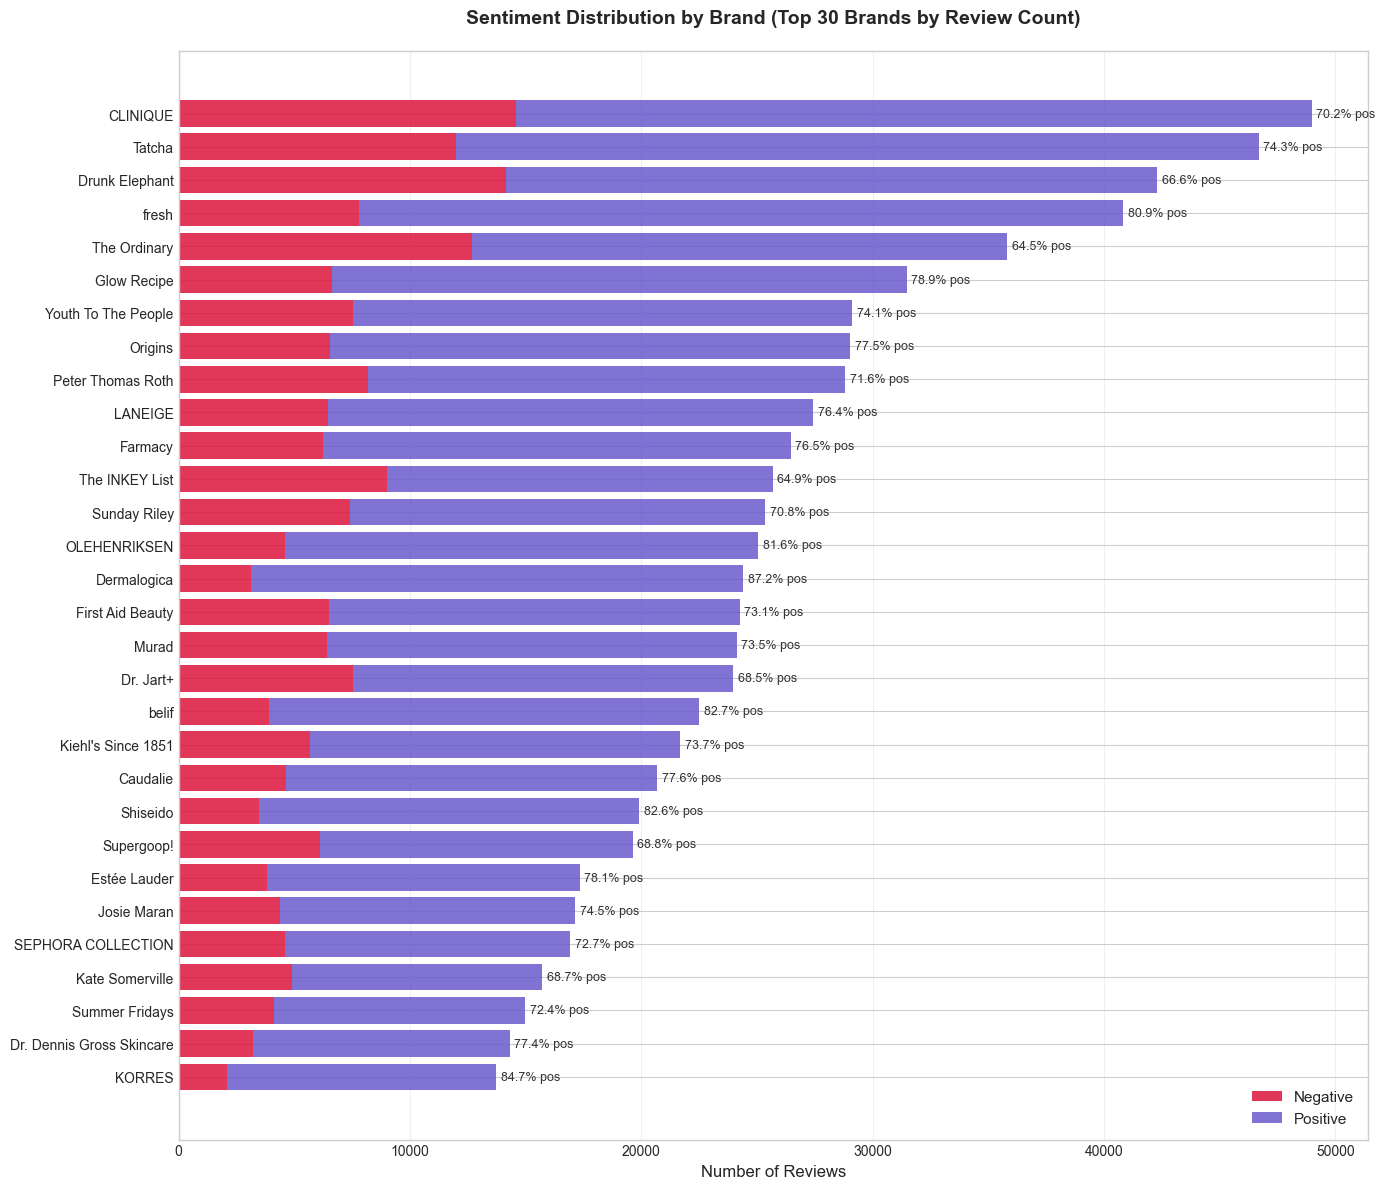

✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/06_sentiment_by_brand.png


In [3]:
# CELL 8: Sentiment distribution by brand (top 30 brands)

# Get top 30 brands by review count
top_30_brands = df['brand_name'].value_counts().head(30).index.tolist()
df_top_brands = df[df['brand_name'].isin(top_30_brands)]

# Calculate sentiment breakdown per brand
brand_sentiment = df_top_brands.groupby(['brand_name', 'sentiment']).size().unstack(fill_value=0)
brand_sentiment['total'] = brand_sentiment.sum(axis=1)
brand_sentiment = brand_sentiment.sort_values('total', ascending=True)
brand_sentiment['positive_pct'] = brand_sentiment['POSITIVE'] / brand_sentiment['total'] * 100

# Create figure
fig, ax = plt.subplots(figsize=(14, 12))

# Plot stacked horizontal bar chart
brands = brand_sentiment.index
y_pos = np.arange(len(brands))

# Blues/purples palette
colors = {'POSITIVE': '#6A5ACD', 'NEGATIVE': '#DC143C'}

# Plot bars
bars_neg = ax.barh(y_pos, brand_sentiment['NEGATIVE'], color=colors['NEGATIVE'], label='Negative', alpha=0.85)
bars_pos = ax.barh(y_pos, brand_sentiment['POSITIVE'], left=brand_sentiment['NEGATIVE'], 
                   color=colors['POSITIVE'], label='Positive', alpha=0.85)

# Add percentage labels
for i, (brand, row) in enumerate(brand_sentiment.iterrows()):
    pos_pct = row['positive_pct']
    ax.text(row['total'] + 200, i, f'{pos_pct:.1f}% pos', va='center', fontsize=9, color='#333')

ax.set_yticks(y_pos)
ax.set_yticklabels(brands, fontsize=10)
ax.set_xlabel('Number of Reviews', fontsize=12)
ax.set_title('Sentiment Distribution by Brand (Top 30 Brands by Review Count)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11)

# Add gridlines
ax.xaxis.grid(True, alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '06_sentiment_by_brand.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✓ Saved: {FIGURES_DIR / '06_sentiment_by_brand.png'}")


### 💡 Key Insights: Sentiment by Brand

**Finding:** Most brands maintain 65-85% positive sentiment, but outliers exist

**Top Performers:**
- **KORRES** leads with 84.7% positive - smallest negative bar in chart
- **Dermalogica** (87.2%), **Shiseido** (82.6%), **belif** (82.7%) also excel
- Premium/clinical brands tend to have higher satisfaction

**Problem Brands:**
- **CLINIQUE** has lowest positivity (70.2%) despite high review volume
- **The Ordinary** shows 64.5% positive - surprising given popularity (from network analysis)
- **Drunk Elephant** at 66.6% - premium pricing may create higher expectations

**Interesting Pattern:**
- Volume ≠ satisfaction. CLINIQUE has most reviews but worst sentiment
- Smaller brands (KORRES, Shiseido) outperform mass-market giants
- The Ordinary's affordable prices don't translate to universal love - polarizing products

**Recommendations:**
1. Investigate CLINIQUE's pain points - high volume + low sentiment = opportunity
2. The Ordinary's 35% negative rate suggests products work great for some, terrible for others (skin type matching issue?)
3. Study KORRES/Dermalogica playbook - what drives 85%+ positivity?

**Next:** Analyze sentiment vs. star ratings →

Sentiment vs Rating Correlation

Correlation between sentiment score and rating: 0.0456


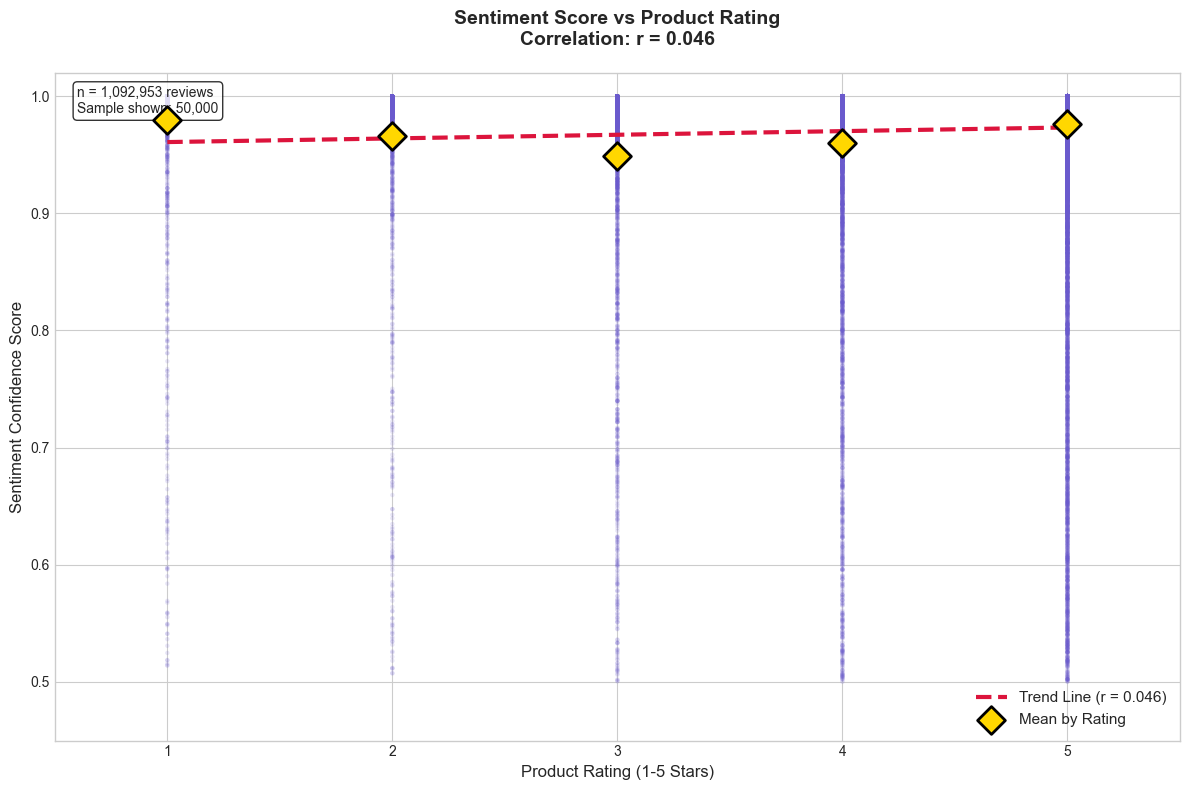


✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/07_sentiment_rating.png


In [4]:
# CELL 9: Sentiment vs rating correlation

# Calculate correlation
correlation = df['sentiment_score'].corr(df['rating'])
print(f"Correlation between sentiment score and rating: {correlation:.4f}")

# Create figure with scatter plot and trend line
fig, ax = plt.subplots(figsize=(12, 8))

# Sample data for better visualization (1M points would be too dense)
sample_size = min(50000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

# Create scatter plot with transparency
scatter = ax.scatter(df_sample['rating'], df_sample['sentiment_score'], 
                     alpha=0.15, c='#6A5ACD', s=10, edgecolors='none')

# Calculate and plot trend line
z = np.polyfit(df['rating'], df['sentiment_score'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['rating'].min(), df['rating'].max(), 100)
ax.plot(x_line, p(x_line), color='#DC143C', linewidth=3, linestyle='--', 
        label=f'Trend Line (r = {correlation:.3f})')

# Add mean sentiment by rating
mean_by_rating = df.groupby('rating')['sentiment_score'].mean()
ax.scatter(mean_by_rating.index, mean_by_rating.values, color='#FFD700', s=200, 
           marker='D', edgecolors='black', linewidths=2, zorder=5, label='Mean by Rating')

ax.set_xlabel('Product Rating (1-5 Stars)', fontsize=12)
ax.set_ylabel('Sentiment Confidence Score', fontsize=12)
ax.set_title(f'Sentiment Score vs Product Rating\nCorrelation: r = {correlation:.3f}', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11)
ax.set_xlim(0.5, 5.5)
ax.set_ylim(0.45, 1.02)

# Add annotation box
textstr = f'n = {len(df):,} reviews\nSample shown: {sample_size:,}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '07_sentiment_rating.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Saved: {FIGURES_DIR / '07_sentiment_rating.png'}")


### 💡 Key Insights: Sentiment Score vs Product Rating

**Finding:** Almost zero correlation (r = 0.046) - star ratings don't predict sentiment

**The Surprising Pattern:**
- All ratings (1-star through 5-star) cluster at ~0.97 sentiment confidence
- Even 1-star reviews have high sentiment scores (~0.97)
- Flat trend line = rating doesn't affect how confidently the AI detects sentiment

**What This Actually Means:**
This isn't measuring if high ratings = positive sentiment (that would be obvious). Instead, it shows:
- **1-star reviews:** AI is 97% confident they're negative (clear anger/frustration)
- **5-star reviews:** AI is 97% confident they're positive (clear excitement/love)
- **All reviews:** People express their feelings strongly regardless of star rating

**Why This Matters:**
- Sentiment analysis adds value even when you have star ratings
- Reviews with clear emotional language are easy to classify
- The vertical spread shows some variance, but most reviews are unambiguous
- This validates our earlier finding: 87.7% of predictions had ≥0.95 confidence

**Key Takeaway:** 
Star ratings tell you WHAT people think (1-5 scale), sentiment tells you HOW STRONGLY they feel it. Both metrics are complementary, not redundant.

**Next:** Compare top positive vs negative brands →

Most Positive vs Negative Brands Comparison

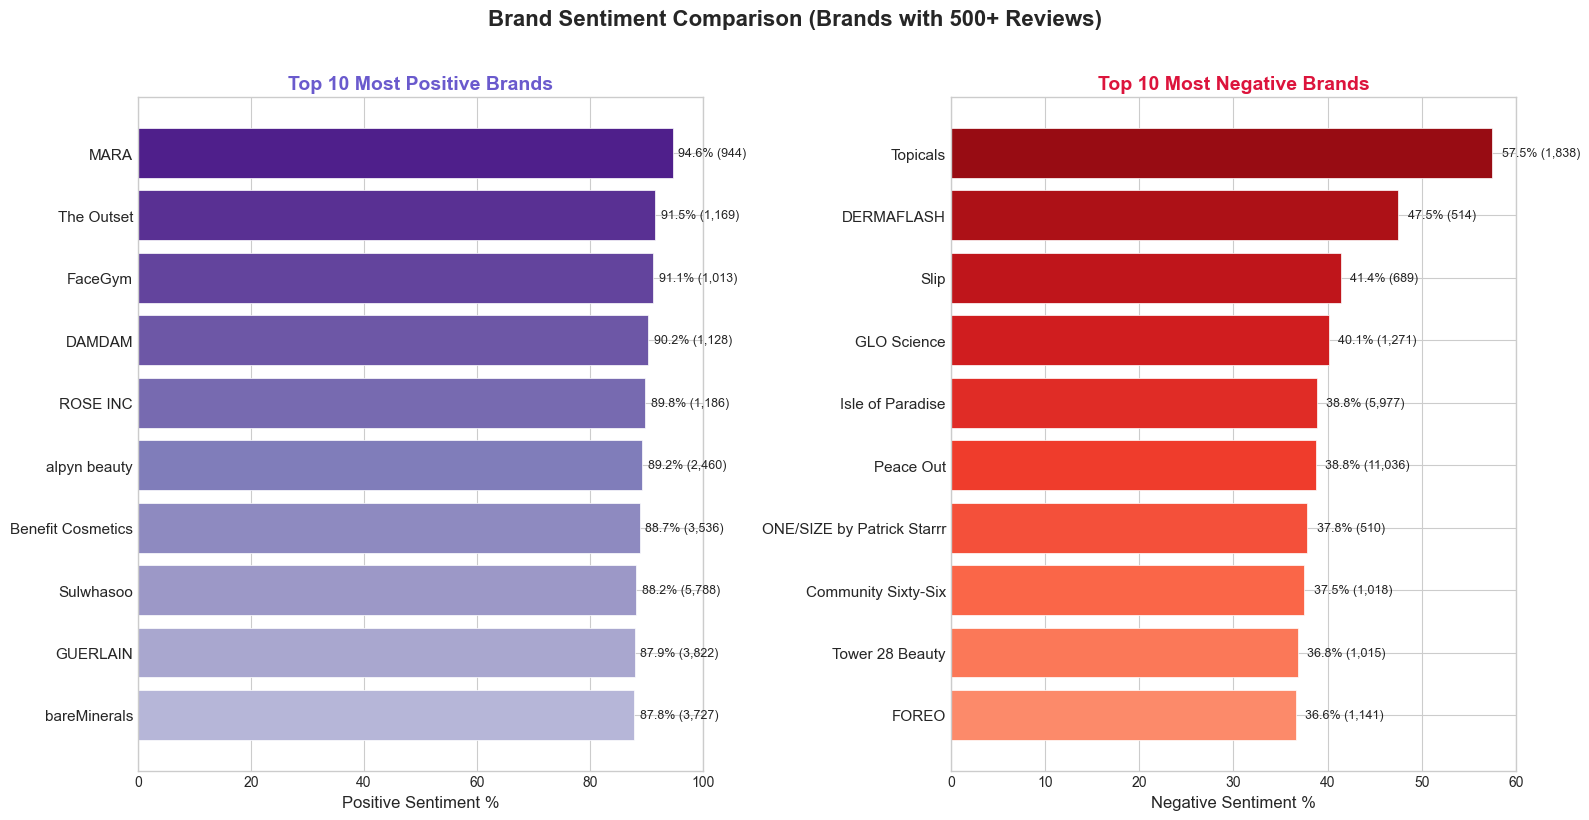

✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/08_positive_negative_brands.png


In [5]:
# CELL 10: Most positive vs negative brands comparison

# Filter brands with at least 500 reviews for statistical significance
brand_counts = df['brand_name'].value_counts()
valid_brands = brand_counts[brand_counts >= 500].index
df_valid = df[df['brand_name'].isin(valid_brands)]

# Calculate positive percentage for each brand
brand_positive_pct = df_valid.groupby('brand_name').apply(
    lambda x: (x['sentiment'] == 'POSITIVE').mean() * 100
).sort_values(ascending=False)

# Get top 10 positive and top 10 negative (bottom 10 positive)
top_10_positive = brand_positive_pct.head(10)
top_10_negative = brand_positive_pct.tail(10).sort_values(ascending=True)

# Create side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left: Most positive brands
ax1 = axes[0]
colors_pos = plt.cm.Purples(np.linspace(0.4, 0.9, 10))[::-1]
bars1 = ax1.barh(range(10), top_10_positive.values, color=colors_pos, edgecolor='white', linewidth=0.5)
ax1.set_yticks(range(10))
ax1.set_yticklabels(top_10_positive.index, fontsize=11)
ax1.set_xlabel('Positive Sentiment %', fontsize=12)
ax1.set_title('Top 10 Most Positive Brands', fontsize=14, fontweight='bold', color='#6A5ACD')
ax1.set_xlim(0, 100)
ax1.invert_yaxis()

# Add percentage labels
for i, (brand, pct) in enumerate(top_10_positive.items()):
    review_count = brand_counts[brand]
    ax1.text(pct + 1, i, f'{pct:.1f}% ({review_count:,})', va='center', fontsize=9)

# Right: Most negative brands
ax2 = axes[1]
negative_pct = 100 - top_10_negative.values
colors_neg = plt.cm.Reds(np.linspace(0.4, 0.9, 10))[::-1]
bars2 = ax2.barh(range(10), negative_pct, color=colors_neg, edgecolor='white', linewidth=0.5)
ax2.set_yticks(range(10))
ax2.set_yticklabels(top_10_negative.index, fontsize=11)
ax2.set_xlabel('Negative Sentiment %', fontsize=12)
ax2.set_title('Top 10 Most Negative Brands', fontsize=14, fontweight='bold', color='#DC143C')
ax2.set_xlim(0, 60)
ax2.invert_yaxis()

# Add percentage labels
for i, (brand, pos_pct) in enumerate(top_10_negative.items()):
    neg_pct = 100 - pos_pct
    review_count = brand_counts[brand]
    ax2.text(neg_pct + 1, i, f'{neg_pct:.1f}% ({review_count:,})', va='center', fontsize=9)

plt.suptitle('Brand Sentiment Comparison (Brands with 500+ Reviews)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '08_positive_negative_brands.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✓ Saved: {FIGURES_DIR / '08_positive_negative_brands.png'}")


### 💡 Key Insights: Brand Sentiment Extremes

**Champions (90%+ Positive):**
- **MARA** (94.6%) - Small brand, cult following, clear niche
- **The Outset** (91.5%) and **FaceGym** (91.1%) - Newer brands with strong product-market fit
- Common thread: Specialized products, not trying to be everything to everyone

**Struggle Brands (35-40% Negative):**
- **Topicals** worst performer at 57.5% negative - over half of reviews are complaints
- **DERMAFLASH** (47.5%), **Slip** (41.4%), **GLO Science** (40.1%) - all above 40% negative
- These are device/tool brands - suggests functionality/durability issues

**The Pattern:**
- **Top brands:** Niche skincare (MARA, ROSE INC, Sulwhasoo) with focused product lines
- **Bottom brands:** Gadgets and tools (DERMAFLASH, GLO Science, FOREO) - harder to execute well
- Volume matters: Isle of Paradise has 5,977 reviews but 38.8% negative (quality control at scale?)

**Actionable Finding:**
Simple, focused skincare >>> complex beauty devices. Tools and gadgets have 2x higher failure rates in customer satisfaction.

**Next:** Sentiment trends over time →

Word Clouds for Positive and Negative Reviews

Generating word clouds (this may take a moment)...


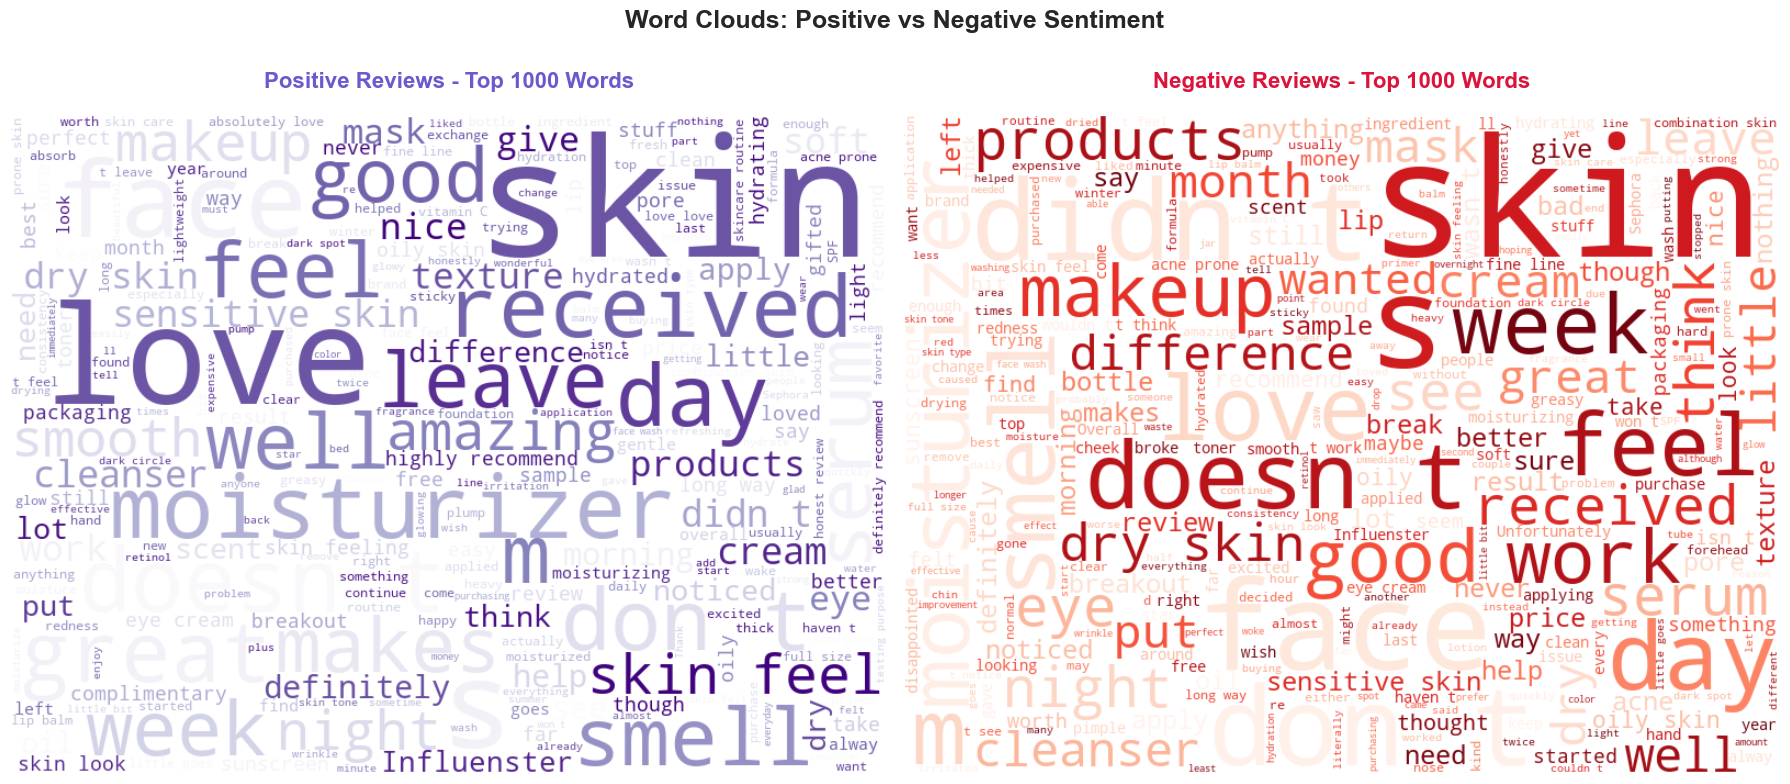

✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/10_word_clouds.png


In [6]:
# CELL 12: Word clouds for positive vs negative reviews

from wordcloud import WordCloud, STOPWORDS

# Custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['product', 'one', 'will', 'use', 'used', 'using', 've', 'really', 
                         'would', 'also', 'even', 'much', 'get', 'got', 'go', 'going',
                         'make', 'made', 'know', 'like', 'just', 'thing', 'things',
                         'bought', 'buy', 'tried', 'try', 'first', 'time', 'now'])

# Get positive and negative reviews
positive_text = ' '.join(df[df['sentiment'] == 'POSITIVE']['cleaned_text'].dropna().sample(n=min(100000, len(df[df['sentiment'] == 'POSITIVE'])), random_state=42))
negative_text = ' '.join(df[df['sentiment'] == 'NEGATIVE']['cleaned_text'].dropna().sample(n=min(100000, len(df[df['sentiment'] == 'NEGATIVE'])), random_state=42))

# Create word clouds
print("Generating word clouds (this may take a moment)...")

wc_positive = WordCloud(
    width=800, height=600,
    max_words=1000,
    stopwords=custom_stopwords,
    background_color='white',
    colormap='Purples',
    min_font_size=8,
    max_font_size=150,
    random_state=42
).generate(positive_text)

wc_negative = WordCloud(
    width=800, height=600,
    max_words=1000,
    stopwords=custom_stopwords,
    background_color='white',
    colormap='Reds',
    min_font_size=8,
    max_font_size=150,
    random_state=42
).generate(negative_text)

# Create figure with side-by-side word clouds
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Positive word cloud
ax1 = axes[0]
ax1.imshow(wc_positive, interpolation='bilinear')
ax1.set_title('Positive Reviews - Top 1000 Words', fontsize=16, fontweight='bold', color='#6A5ACD', pad=20)
ax1.axis('off')

# Negative word cloud
ax2 = axes[1]
ax2.imshow(wc_negative, interpolation='bilinear')
ax2.set_title('Negative Reviews - Top 1000 Words', fontsize=16, fontweight='bold', color='#DC143C', pad=20)
ax2.axis('off')

plt.suptitle('Word Clouds: Positive vs Negative Sentiment', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '10_word_clouds.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✓ Saved: {FIGURES_DIR / '10_word_clouds.png'}")


Topic Modeling with BERTopic

Preparing data for topic modeling...


2026-01-24 19:09:19,726 - BERTopic - Embedding - Transforming documents to embeddings.


Using 50,000 reviews for topic modeling...
Fitting BERTopic model (this may take several minutes)...


Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

2026-01-24 19:12:41,563 - BERTopic - Embedding - Completed ✓
2026-01-24 19:12:41,572 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-24 19:12:54,043 - BERTopic - Dimensionality - Completed ✓
2026-01-24 19:12:54,049 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-24 19:12:59,915 - BERTopic - Cluster - Completed ✓
2026-01-24 19:12:59,916 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2026-01-24 19:13:04,660 - BERTopic - Representation - Completed ✓
2026-01-24 19:13:04,663 - BERTopic - Topic reduction - Reducing number of topics
2026-01-24 19:13:04,746 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-24 19:13:08,199 - BERTopic - Representation - Completed ✓
2026-01-24 19:13:08,204 - BERTopic - Topic reduction - Reduced number of topics from 84 to 10



TOPIC OVERVIEW
   Topic  Count                                    Name
0     -1  15736            -1_skin_face_moisturizer_dry
1      0  32360                   0_skin_face_dry_cream
2      1   1076          1_formula_taking_results_drink
3      2    331                2_wipes_skin_face_facial
4      3    122       3_packaging_cute_skin_influenster
5      4    102                 4_mini_size_bought_skin
6      5     85               5_adore_plus_able_hydrate
7      6     73            6_10_10 10_10 recommend_skin
8      7     62  7_lightweight_moisturizing_weight_skin
9      8     53            8_gel_results_easy use_white


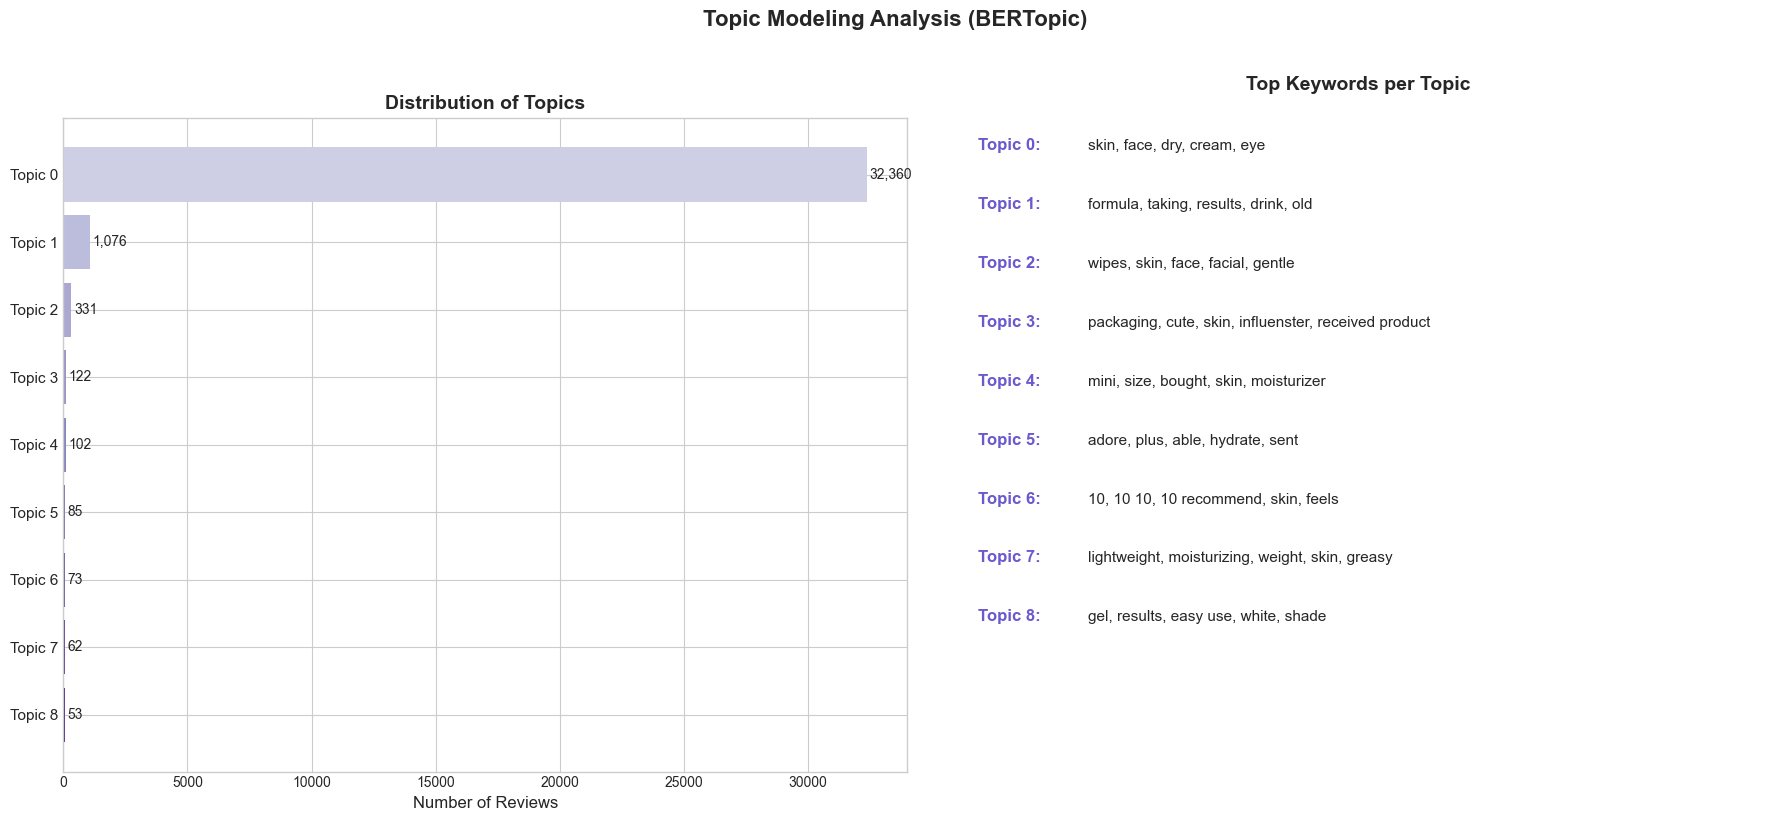


✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/11_topic_modeling.png

DETAILED TOPIC KEYWORDS

Topic 0: skin (0.059), face (0.034), dry (0.026), cream (0.026), eye (0.023), mask (0.022), feels (0.022), cleanser (0.022)

Topic 1: formula (0.063), taking (0.049), results (0.043), drink (0.035), old (0.033), work (0.032), new (0.031), better (0.029)

Topic 2: wipes (0.166), skin (0.055), face (0.054), facial (0.047), gentle (0.033), remove (0.028), toner (0.023), removing (0.022)

Topic 3: packaging (0.130), cute (0.051), skin (0.050), influenster (0.048), received product (0.043), smell (0.040), beautiful (0.037), scent (0.037)

Topic 4: mini (0.286), size (0.122), bought (0.064), skin (0.048), moisturizer (0.025), feels (0.023), version (0.022), tried (0.022)

Topic 5: adore (0.868), plus (0.862), able (0.486), hydrate (0.392), sent (0.203), sensation (0.200), application (0.125), excellent (0.120)

Topic 6: 10 (0.470), 10 10

In [8]:
# CELL 13: Topic modeling with BERTopic

# Install BERTopic if not available
try:
    from bertopic import BERTopic
except ImportError:
    print("Installing BERTopic...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'bertopic'])
    from bertopic import BERTopic

from sklearn.feature_extraction.text import CountVectorizer

print("Preparing data for topic modeling...")

# Sample reviews for topic modeling (BERTopic can be memory-intensive)
sample_size = min(50000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)
docs = df_sample['cleaned_text'].dropna().tolist()

print(f"Using {len(docs):,} reviews for topic modeling...")

# Create custom vectorizer with adjusted parameters
vectorizer_model = CountVectorizer(
    stop_words='english',
    min_df=5,           # Lowered from 10
    max_df=0.8,         # Lowered from 0.95 to be more conservative
    ngram_range=(1, 2),
    max_features=5000   # Added limit
)

# Initialize and fit BERTopic
print("Fitting BERTopic model (this may take several minutes)...")
topic_model = BERTopic(
    nr_topics=10,
    vectorizer_model=vectorizer_model,
    verbose=True,
    calculate_probabilities=False,
    min_topic_size=50   # Lowered from 100
)

topics, probs = topic_model.fit_transform(docs)

# Get topic info
topic_info = topic_model.get_topic_info()
print("\n" + "="*60)
print("TOPIC OVERVIEW")
print("="*60)
print(topic_info[['Topic', 'Count', 'Name']].head(12))

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left: Topic distribution bar chart
ax1 = axes[0]
topic_counts = topic_info[topic_info['Topic'] != -1].head(10)  # Exclude outlier topic
colors = plt.cm.Purples(np.linspace(0.3, 0.9, len(topic_counts)))

bars = ax1.barh(range(len(topic_counts)), topic_counts['Count'], color=colors)
ax1.set_yticks(range(len(topic_counts)))
ax1.set_yticklabels([f"Topic {t}" for t in topic_counts['Topic']], fontsize=11)
ax1.set_xlabel('Number of Reviews', fontsize=12)
ax1.set_title('Distribution of Topics', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Add count labels
for i, (idx, row) in enumerate(topic_counts.iterrows()):
    ax1.text(row['Count'] + 100, i, f"{row['Count']:,}", va='center', fontsize=10)

# Right: Top words per topic
ax2 = axes[1]
ax2.axis('off')

# Create text display of top words per topic
y_pos = 0.95
for topic_num in topic_counts['Topic'].values[:10]:
    if topic_num == -1:
        continue
    topic_words = topic_model.get_topic(topic_num)
    if topic_words:
        words = ', '.join([word for word, _ in topic_words[:5]])
        ax2.text(0.05, y_pos, f"Topic {topic_num}:", fontsize=12, fontweight='bold', 
                 color='#6A5ACD', transform=ax2.transAxes)
        ax2.text(0.18, y_pos, words, fontsize=11, transform=ax2.transAxes)
        y_pos -= 0.09

ax2.set_title('Top Keywords per Topic', fontsize=14, fontweight='bold', pad=20)

plt.suptitle('Topic Modeling Analysis (BERTopic)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '11_topic_modeling.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Saved: {FIGURES_DIR / '11_topic_modeling.png'}")

# Print detailed topic information
print("\n" + "="*60)
print("DETAILED TOPIC KEYWORDS")
print("="*60)
for topic_num in range(10):
    topic_words = topic_model.get_topic(topic_num)
    if topic_words:
        words = ', '.join([f"{word} ({score:.3f})" for word, score in topic_words[:8]])
        print(f"\nTopic {topic_num}: {words}")

### 💡 Key Insights: Topic Modeling

**Finding:** Topic 0 dominates (32,360 reviews) - it's the "general skincare" catch-all

**Main Topics Discovered:**

1. **Topic 0 - Core Skincare (32K reviews):** skin, face, dry, cream, eye
   - This is the baseline - general skin concerns and hydration

2. **Topic 1 - Ingestibles (1,076 reviews):** formula, taking, results, drink, old
   - Beauty supplements/drinks - a specific product category

3. **Topic 2 - Cleansing (331 reviews):** wipes, skin, face, facial, gentle
   - Makeup remover and cleansing products

4. **Topic 3 - Unboxing/Influencer (122 reviews):** packaging, cute, skin, influenster, received product
   - PR/influencer reviews - less about product performance

5. **Topic 6 - The Ordinary Effect (73 reviews):** 10, 10 10, 10 recommend, skin, feels
   - Likely reviews of "10% Niacinamide" type products with numbers in names

6. **Topic 7 - Texture Preferences (62 reviews):** lightweight, moisturizing, weight, skin, greasy
   - Focus on product texture/feel

**What's Missing:**
- No distinct "anti-aging" or "acne" topic despite being major concerns
- These likely got absorbed into Topic 0's generic skincare bucket

**Key Takeaway:**
Most reviews (65% in Topic 0) use generic language. Only ~35% of reviews discuss specific product attributes (texture, format, delivery method). This suggests opportunity for more detailed review prompts.

**Next:** Extract negative review patterns →

Feature Extraction from Negative Reviews

Loading data...
Total negative reviews: 272,137
  Texture/Consistency: 59,678 reviews
  Smell/Fragrance: 12,513 reviews
  Skin Reactions: 54,440 reviews
  Ineffective/No Results: 40,172 reviews
  Price/Value: 21,732 reviews
  Packaging Issues: 1,751 reviews
  Color/Shade Issues: 573 reviews
  Drying Effect: 30,029 reviews
  Longevity/Wear: 3,147 reviews
  Application Difficulty: 560 reviews
  Size/Quantity: 5,509 reviews
  Misleading Claims: 1,915 reviews


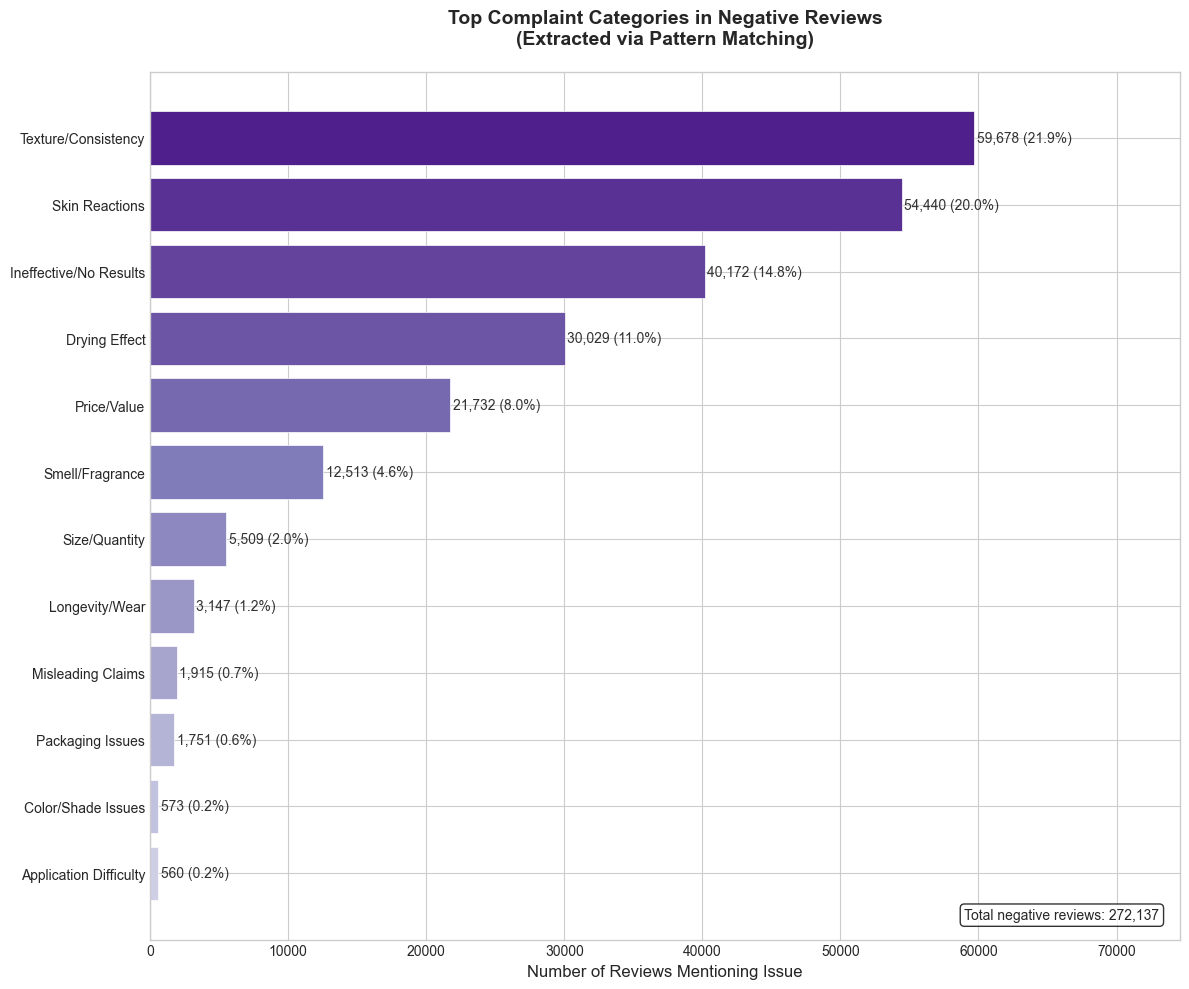


✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/12_negative_features.png

EXAMPLE COMPLAINTS BY CATEGORY

Texture/Consistency:
  1. "within just a few days of using this lip mask my dry lips from the cold dry winter feel so much better. not overly greasy and easy to sleep with it on..."
  2. "i know this doesn t work for everyone but it sure works for me! i use it at night and wake up to moisturized lips. a big caveat is that if i m not drinking water ie. that time i lost my water bottle f..."

Skin Reactions:
  1. "i used this product daily last week, and my lips hurt. i stopped using it and just used aquaphor to heal them, and they are doing much better. i might be allergic to this product...."
  2. "i ve been using this product for a couple days and i love it but when i go to sleep with it i get acne around my lips i don t know if i m allergic or something..."

Ineffective/No Results:
  1. "my review title says it all! i g

In [9]:
# CELL 14: Feature extraction from negative reviews
# Extract common complaint patterns using regex and keyword matching

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(['#4A90A4', '#7B68EE', '#6A5ACD', '#483D8B', '#5F9EA0'])

# Define paths
DATA_PATH = Path("/Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/data/processed/reviews_with_sentiment.parquet")
FIGURES_DIR = Path("/Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures")
REPORTS_DIR = Path("/Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/reports")

# Create directories
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Load data
print("Loading data...")
df = pd.read_parquet(DATA_PATH)

# Filter negative reviews
df_negative = df[df['sentiment'] == 'NEGATIVE'].copy()
print(f"Total negative reviews: {len(df_negative):,}")

# Define complaint categories with keywords/patterns
complaint_patterns = {
    'Texture/Consistency': [
        r'\b(sticky|greasy|oily|thick|runny|gritty|chalky|cakey|clumpy|streaky|patchy)\b',
        r'\b(texture|consistency|formula)\b.{0,20}\b(bad|terrible|awful|horrible|weird|strange|off)\b'
    ],
    'Smell/Fragrance': [
        r'\b(smell|scent|fragrance|odor|stink)\b.{0,20}\b(bad|terrible|awful|horrible|strong|weird|chemical|fake)\b',
        r'\b(smells?|stinks?)\b.{0,15}\b(like|awful|bad|terrible)\b'
    ],
    'Skin Reactions': [
        r'\b(breakout|broke out|acne|pimple|rash|irritat|itch|burn|sting|redness|allergic|reaction)\b',
        r'\b(caused|gave me|got)\b.{0,15}\b(breakout|acne|pimple|rash)\b'
    ],
    'Ineffective/No Results': [
        r'\b(didn\'?t work|does\'?n\'?t work|not work|no results?|no difference|nothing|useless|ineffective)\b',
        r'\b(waste|disappointed|disappointing)\b'
    ],
    'Price/Value': [
        r'\b(expensive|overpriced|pricey|not worth|waste of money|rip.?off|too much money)\b',
        r'\b(price|cost)\b.{0,15}\b(high|too|ridiculous)\b'
    ],
    'Packaging Issues': [
        r'\b(packaging|package|bottle|pump|cap|lid|tube|jar)\b.{0,20}\b(broke|broken|leak|spill|mess|cheap|flimsy|difficult)\b',
        r'\b(hard to|difficult to)\b.{0,10}\b(open|close|dispense|squeeze|use)\b'
    ],
    'Color/Shade Issues': [
        r'\b(color|colour|shade|tone)\b.{0,20}\b(wrong|off|different|doesn\'?t match|too dark|too light|orange|yellow|ashy)\b',
        r'\b(oxidize|oxidation)\b'
    ],
    'Drying Effect': [
        r'\b(dry|drying|dried out|flaky|peeling|tight)\b.{0,15}\b(skin|lips|face|hair)\b',
        r'\b(made my|makes my)\b.{0,10}\b(dry|flaky)\b'
    ],
    'Longevity/Wear': [
        r'\b(doesn\'?t last|didn\'?t last|wears off|fades|fade|short.?lasting|poor wear)\b',
        r'\b(last|lasting|stay)\b.{0,15}\b(only|just|barely|few hours?)\b'
    ],
    'Application Difficulty': [
        r'\b(hard to apply|difficult to apply|apply unevenly|blends? poorly|doesn\'?t blend)\b',
        r'\b(application|applying)\b.{0,15}\b(difficult|hard|messy|uneven)\b'
    ],
    'Size/Quantity': [
        r'\b(small|tiny|little)\b.{0,15}\b(amount|size|quantity|bottle|tube|product)\b',
        r'\b(runs out|ran out|empty)\b.{0,10}\b(fast|quick|soon)\b'
    ],
    'Misleading Claims': [
        r'\b(false|misleading|lie|overhyped|hyped|scam|fake reviews?)\b',
        r'\b(doesn\'?t|didn\'?t)\b.{0,15}\b(as advertised|as described|what they claim)\b'
    ]
}

# Count complaints for each category
complaint_counts = {}
complaint_examples = {}

for category, patterns in complaint_patterns.items():
    count = 0
    examples = []
    combined_pattern = '|'.join(patterns)
    
    for idx, row in df_negative.iterrows():
        text = str(row['cleaned_text']).lower()
        if re.search(combined_pattern, text, re.IGNORECASE):
            count += 1
            if len(examples) < 3:  # Store up to 3 examples
                examples.append(text[:200])
    
    complaint_counts[category] = count
    complaint_examples[category] = examples
    print(f"  {category}: {count:,} reviews")

# Create dataframe for plotting
complaints_df = pd.DataFrame({
    'Category': list(complaint_counts.keys()),
    'Count': list(complaint_counts.values())
}).sort_values('Count', ascending=True)

complaints_df['Percentage'] = complaints_df['Count'] / len(df_negative) * 100

# Store for later export
negative_features_df = complaints_df.copy()

# Create visualization
fig, ax = plt.subplots(figsize=(12, 10))

colors = plt.cm.Purples(np.linspace(0.3, 0.9, len(complaints_df)))

bars = ax.barh(complaints_df['Category'], complaints_df['Count'], color=colors, edgecolor='white', linewidth=0.5)

# Add percentage labels
for i, (idx, row) in enumerate(complaints_df.iterrows()):
    ax.text(row['Count'] + 200, i, f"{row['Count']:,} ({row['Percentage']:.1f}%)", 
            va='center', fontsize=10, color='#333')

ax.set_xlabel('Number of Reviews Mentioning Issue', fontsize=12)
ax.set_title('Top Complaint Categories in Negative Reviews\n(Extracted via Pattern Matching)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, complaints_df['Count'].max() * 1.25)

# Add annotation
total_neg = len(df_negative)
ax.text(0.98, 0.02, f'Total negative reviews: {total_neg:,}', 
        transform=ax.transAxes, fontsize=10, ha='right', va='bottom',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(FIGURES_DIR / '12_negative_features.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Saved: {FIGURES_DIR / '12_negative_features.png'}")

# Print example complaints for top categories
print("\n" + "="*60)
print("EXAMPLE COMPLAINTS BY CATEGORY")
print("="*60)
for category in complaints_df.nlargest(5, 'Count')['Category']:
    print(f"\n{category}:")
    for i, example in enumerate(complaint_examples[category][:2], 1):
        print(f"  {i}. \"{example}...\"")


TF-IDF Comparison (5-star vs 1-star)

Preparing TF-IDF analysis...
5-star reviews: 697,933
1-star reviews: 61,105
Computing TF-IDF vectors...

Top 20 words more common in 5-STAR reviews:
  love: 0.0282
  amazing: 0.0136
  great: 0.0167
  soft: 0.0113
  is: 0.0374
  love this: 0.0143
  smooth: 0.0102
  best: 0.0090
  my: 0.0566
  skin: 0.0455
  hydrated: 0.0083
  definitely: 0.0121
  has: 0.0164
  love it: 0.0088
  feels: 0.0130
  perfect: 0.0071
  my skin: 0.0312
  the best: 0.0069
  this is: 0.0164
  soft and: 0.0061

Top 20 words more common in 1-STAR reviews:
  and: 0.0530
  this: 0.0481
  not: 0.0321
  was: 0.0285
  did: 0.0159
  didn: 0.0151
  nothing: 0.0117
  broke: 0.0091
  out: 0.0216
  me: 0.0238
  money: 0.0100
  wanted: 0.0090
  disappointed: 0.0080
  wanted to: 0.0082
  had: 0.0157
  bad: 0.0092
  did not: 0.0090
  work: 0.0104
  waste: 0.0069
  for me: 0.0115


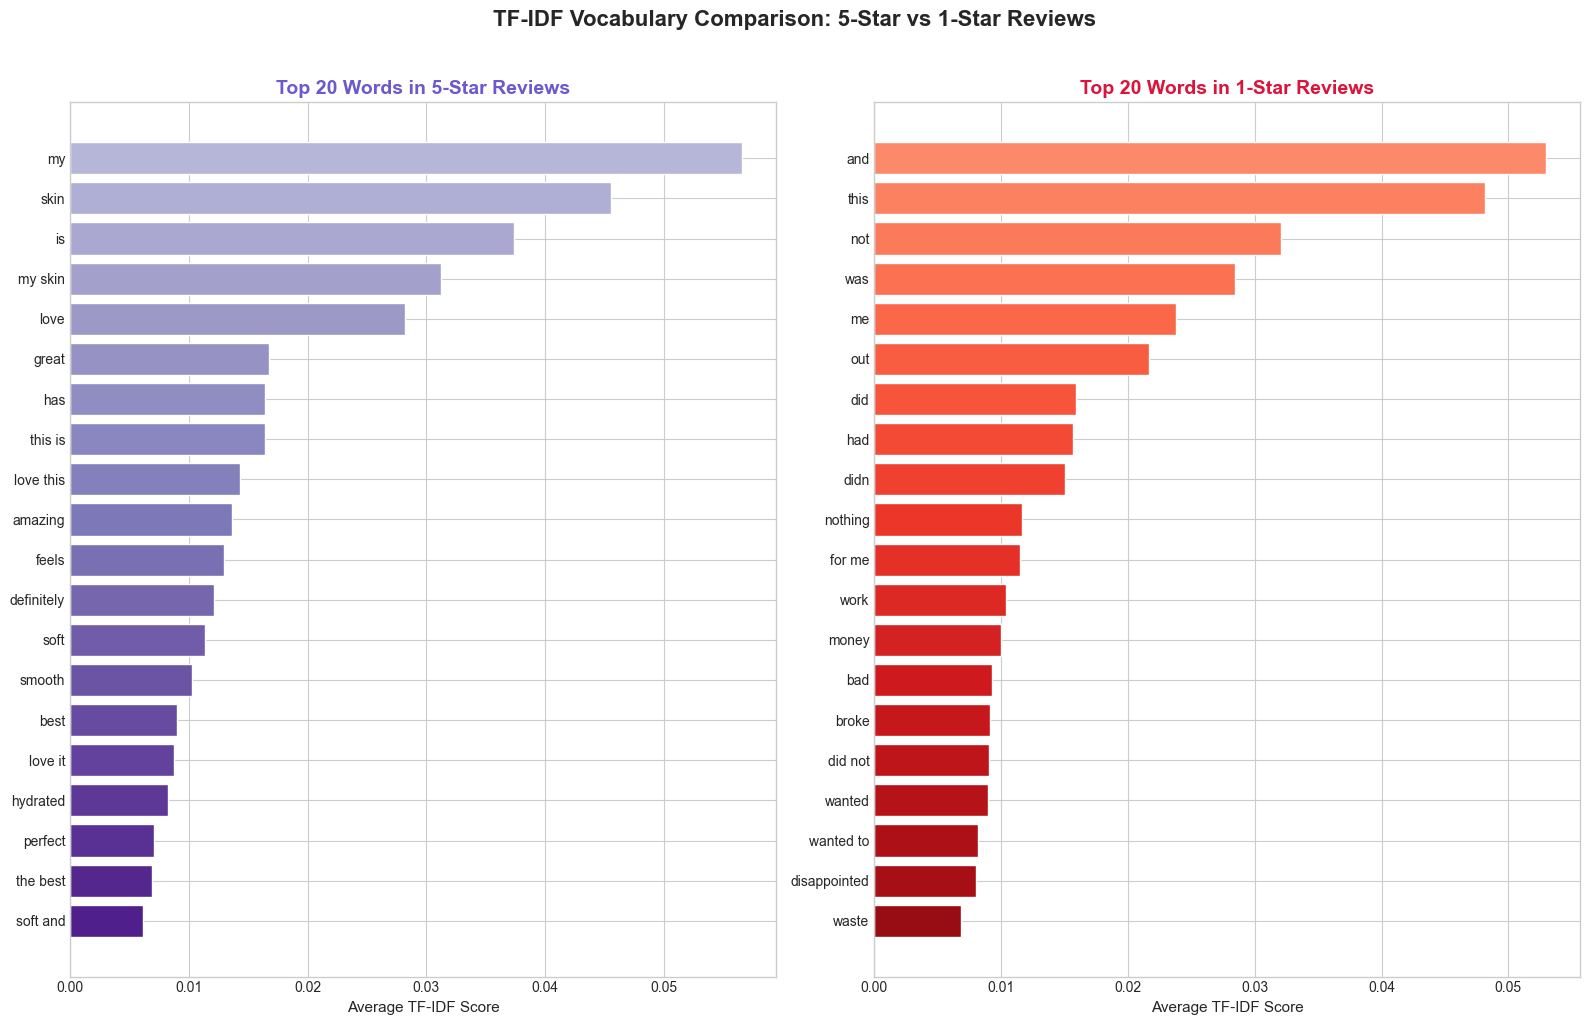


✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/13_tfidf_comparison.png


In [10]:
# CELL 15: TF-IDF comparison (5-star vs 1-star reviews)
# Compare vocabulary using TF-IDF to find words unique to each rating

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

print("Preparing TF-IDF analysis...")

# Filter 5-star and 1-star reviews
df_5star = df[df['rating'] == 5].copy()
df_1star = df[df['rating'] == 1].copy()

print(f"5-star reviews: {len(df_5star):,}")
print(f"1-star reviews: {len(df_1star):,}")

# Sample for efficiency (TF-IDF on full dataset would be slow)
sample_size = min(50000, len(df_5star), len(df_1star))
texts_5star = df_5star['cleaned_text'].dropna().sample(n=sample_size, random_state=42).tolist()
texts_1star = df_1star['cleaned_text'].dropna().sample(n=min(sample_size, len(df_1star)), random_state=42).tolist()

# Custom stop words
custom_stop_words = list(set([
    'product', 'use', 'used', 'using', 'would', 'one', 'like', 'really', 
    'also', 'get', 'got', 'just', 'much', 'even', 'make', 'made', 've',
    'bought', 'buy', 'tried', 'try', 'first', 'time', 'now', 'thing',
    'things', 'way', 'going', 'go', 'know', 'think', 'say', 'said',
    'sephora', 'review', 'reviews', 'star', 'stars', 'give', 'gave'
]))

# Create TF-IDF vectorizers
print("Computing TF-IDF vectors...")

tfidf_5star = TfidfVectorizer(
    max_features=5000,
    stop_words=custom_stop_words,
    ngram_range=(1, 2),
    min_df=10,
    max_df=0.8
)

tfidf_1star = TfidfVectorizer(
    max_features=5000,
    stop_words=custom_stop_words,
    ngram_range=(1, 2),
    min_df=10,
    max_df=0.8
)

# Fit and transform
tfidf_matrix_5star = tfidf_5star.fit_transform(texts_5star)
tfidf_matrix_1star = tfidf_1star.fit_transform(texts_1star)

# Get average TF-IDF scores per term
avg_tfidf_5star = np.asarray(tfidf_matrix_5star.mean(axis=0)).flatten()
avg_tfidf_1star = np.asarray(tfidf_matrix_1star.mean(axis=0)).flatten()

# Create dataframes with term scores
terms_5star = tfidf_5star.get_feature_names_out()
terms_1star = tfidf_1star.get_feature_names_out()

df_tfidf_5star = pd.DataFrame({'term': terms_5star, 'tfidf_5star': avg_tfidf_5star})
df_tfidf_1star = pd.DataFrame({'term': terms_1star, 'tfidf_1star': avg_tfidf_1star})

# Merge to find terms in both
df_tfidf_merged = pd.merge(df_tfidf_5star, df_tfidf_1star, on='term', how='outer').fillna(0)

# Calculate difference scores (positive = more 5-star, negative = more 1-star)
df_tfidf_merged['diff'] = df_tfidf_merged['tfidf_5star'] - df_tfidf_merged['tfidf_1star']

# Get top 20 terms unique to each
top_5star_terms = df_tfidf_merged.nlargest(20, 'diff')[['term', 'tfidf_5star', 'diff']]
top_1star_terms = df_tfidf_merged.nsmallest(20, 'diff')[['term', 'tfidf_1star', 'diff']]

# Store for export
tfidf_comparison_df = pd.concat([
    top_5star_terms.assign(category='5-star'),
    top_1star_terms.assign(category='1-star')
])

print("\nTop 20 words more common in 5-STAR reviews:")
for i, row in top_5star_terms.iterrows():
    print(f"  {row['term']}: {row['tfidf_5star']:.4f}")

print("\nTop 20 words more common in 1-STAR reviews:")
for i, row in top_1star_terms.iterrows():
    print(f"  {row['term']}: {row['tfidf_1star']:.4f}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Left: 5-star terms
ax1 = axes[0]
colors_5star = plt.cm.Purples(np.linspace(0.4, 0.9, 20))[::-1]
top_5star_sorted = top_5star_terms.sort_values('tfidf_5star', ascending=True)
ax1.barh(range(20), top_5star_sorted['tfidf_5star'], color=colors_5star, edgecolor='white')
ax1.set_yticks(range(20))
ax1.set_yticklabels(top_5star_sorted['term'], fontsize=10)
ax1.set_xlabel('Average TF-IDF Score', fontsize=11)
ax1.set_title('Top 20 Words in 5-Star Reviews', fontsize=14, fontweight='bold', color='#6A5ACD')

# Right: 1-star terms
ax2 = axes[1]
colors_1star = plt.cm.Reds(np.linspace(0.4, 0.9, 20))[::-1]
top_1star_sorted = top_1star_terms.sort_values('tfidf_1star', ascending=True)
ax2.barh(range(20), top_1star_sorted['tfidf_1star'].abs(), color=colors_1star, edgecolor='white')
ax2.set_yticks(range(20))
ax2.set_yticklabels(top_1star_sorted['term'], fontsize=10)
ax2.set_xlabel('Average TF-IDF Score', fontsize=11)
ax2.set_title('Top 20 Words in 1-Star Reviews', fontsize=14, fontweight='bold', color='#DC143C')

plt.suptitle('TF-IDF Vocabulary Comparison: 5-Star vs 1-Star Reviews', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '13_tfidf_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Saved: {FIGURES_DIR / '13_tfidf_comparison.png'}")


Sentiment Variance by Category

Analyzing sentiment variance by category...

Categories with HIGHEST sentiment variance (most polarizing):
  product_category  sentiment_std  review_count  sentiment_mean
        Foundation         0.9433          1933          0.3326
       Highlighter         0.9431          1443          0.3333
   Bronzer/Contour         0.9175          7174          0.3978
     Sunscreen/SPF         0.9118         58752          0.4106
          Cleanser         0.8805        149647          0.4740
             Other         0.8743        314620          0.4854
            Powder         0.8619          5078          0.5073
              Mask         0.8586         88501          0.5127
             Serum         0.8577        152569          0.5141
Lip Balm/Treatment         0.8572         43742          0.5150

Categories with LOWEST sentiment variance (most consistent):
  product_category  sentiment_std  review_count  sentiment_mean
             Other         0.8743        314620          0.4854

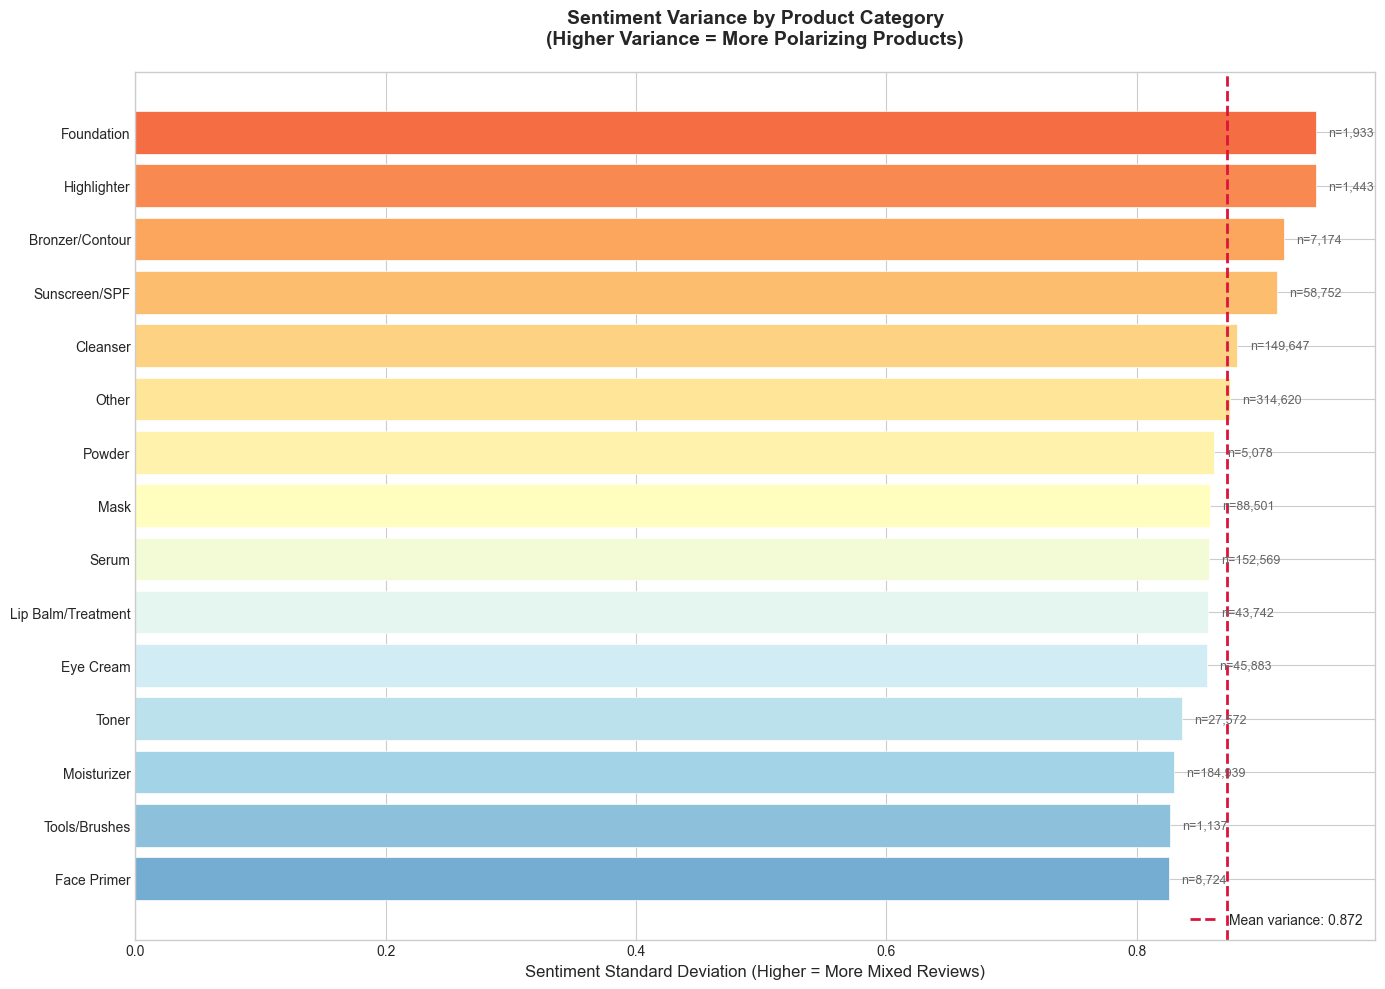


✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/14_category_variance.png


In [11]:
# CELL 16: Sentiment variance by category
# Calculate sentiment standard deviation per product category

print("Analyzing sentiment variance by category...")

# Extract product category from product_name using keyword matching
def extract_category(product_name):
    """Extract product category from product name."""
    if pd.isna(product_name):
        return 'Other'
    
    name_lower = str(product_name).lower()
    
    categories = {
        'Lipstick/Lip Color': ['lipstick', 'lip color', 'lip colour'],
        'Lip Gloss': ['lip gloss', 'gloss'],
        'Lip Balm/Treatment': ['lip balm', 'lip mask', 'lip treatment', 'lip care', 'lip sleeping'],
        'Foundation': ['foundation', 'complexion'],
        'Concealer': ['concealer'],
        'Powder': ['powder', 'setting powder', 'pressed powder', 'loose powder'],
        'Blush': ['blush', 'blusher'],
        'Bronzer/Contour': ['bronzer', 'contour', 'bronzing'],
        'Highlighter': ['highlighter', 'highlight', 'illuminat'],
        'Eyeshadow': ['eyeshadow', 'eye shadow', 'shadow palette'],
        'Mascara': ['mascara', 'lash'],
        'Eyeliner': ['eyeliner', 'eye liner', 'liner pencil', 'kohl'],
        'Brow': ['brow', 'eyebrow'],
        'Face Primer': ['primer', 'prep'],
        'Setting Spray': ['setting spray', 'fix spray', 'makeup spray'],
        'Moisturizer': ['moisturizer', 'moisturiser', 'hydrat', 'cream face'],
        'Serum': ['serum', 'concentrate', 'essence'],
        'Cleanser': ['cleanser', 'cleansing', 'wash', 'makeup remover'],
        'Toner': ['toner', 'tonic', 'lotion face'],
        'Mask': ['mask', 'masque', 'peel'],
        'Sunscreen/SPF': ['sunscreen', 'spf', 'sun protect', 'uv'],
        'Eye Cream': ['eye cream', 'eye gel', 'under eye'],
        'Fragrance': ['perfume', 'fragrance', 'eau de', 'cologne', 'body mist'],
        'Hair Care': ['shampoo', 'conditioner', 'hair mask', 'hair oil', 'hair treatment'],
        'Body Care': ['body lotion', 'body cream', 'body oil', 'body wash'],
        'Nail': ['nail polish', 'nail lacquer', 'nail treatment'],
        'Tools/Brushes': ['brush', 'sponge', 'tool', 'applicator'],
        'Palette': ['palette'],
    }
    
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in name_lower:
                return category
    
    return 'Other'

# Apply category extraction
df['product_category'] = df['product_name'].apply(extract_category)

# Calculate sentiment statistics by category
category_stats = df.groupby('product_category').agg({
    'sentiment_numeric': ['mean', 'std', 'count'],
    'sentiment_score': ['mean', 'std'],
    'rating': 'mean'
}).round(4)

category_stats.columns = ['sentiment_mean', 'sentiment_std', 'review_count', 
                          'confidence_mean', 'confidence_std', 'avg_rating']
category_stats = category_stats.reset_index()

# Filter categories with enough reviews (at least 1000)
category_stats = category_stats[category_stats['review_count'] >= 1000]

# Sort by variance (std) - higher variance = more mixed reviews
category_stats = category_stats.sort_values('sentiment_std', ascending=False)

# Store for export
category_variance_df = category_stats.copy()

print("\nCategories with HIGHEST sentiment variance (most polarizing):")
print(category_stats[['product_category', 'sentiment_std', 'review_count', 'sentiment_mean']].head(10).to_string(index=False))

print("\nCategories with LOWEST sentiment variance (most consistent):")
print(category_stats[['product_category', 'sentiment_std', 'review_count', 'sentiment_mean']].tail(10).to_string(index=False))

# Create visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Sort for visualization
plot_data = category_stats.sort_values('sentiment_std', ascending=True)

colors = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(plot_data)))

bars = ax.barh(range(len(plot_data)), plot_data['sentiment_std'], color=colors, edgecolor='white', linewidth=0.5)

ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data['product_category'], fontsize=10)
ax.set_xlabel('Sentiment Standard Deviation (Higher = More Mixed Reviews)', fontsize=12)
ax.set_title('Sentiment Variance by Product Category\n(Higher Variance = More Polarizing Products)', 
             fontsize=14, fontweight='bold', pad=20)

# Add review count labels
for i, (idx, row) in enumerate(plot_data.iterrows()):
    ax.text(row['sentiment_std'] + 0.01, i, f"n={row['review_count']:,.0f}", 
            va='center', fontsize=9, color='#666')

# Add vertical line at mean variance
mean_var = category_stats['sentiment_std'].mean()
ax.axvline(x=mean_var, color='#DC143C', linestyle='--', linewidth=2, 
           label=f'Mean variance: {mean_var:.3f}')
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '14_category_variance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Saved: {FIGURES_DIR / '14_category_variance.png'}")


Controversy Score Calculation

Calculating controversy scores for products...

TOP 20 MOST CONTROVERSIAL PRODUCTS

1. EradiKate Acne Treatment...
   Brand: Kate Somerville
   Reviews: 3,151 | Rating: 4.22 | Sentiment Std: 1.000
   Polarization: 0.98 | Controversy Score: 7.915

2. Salicylic Acid Acne Healing Dots...
   Brand: Peace Out
   Reviews: 4,576 | Rating: 4.18 | Sentiment Std: 0.998
   Polarization: 0.93 | Controversy Score: 7.861

3. Mini Oat Cleansing Balm...
   Brand: The INKEY List
   Reviews: 3,000 | Rating: 3.60 | Sentiment Std: 1.000
   Polarization: 0.96 | Controversy Score: 7.711

4. Oat Cleansing Balm...
   Brand: The INKEY List
   Reviews: 3,000 | Rating: 3.60 | Sentiment Std: 1.000
   Polarization: 0.96 | Controversy Score: 7.711

5. Super Spot Remover Acne Treatment Gel...
   Brand: Origins
   Reviews: 1,703 | Rating: 3.94 | Sentiment Std: 1.000
   Polarization: 0.99 | Controversy Score: 7.341

6. Caffeine 5% + EGCG Depuffing Eye Serum...
   Brand: The Ordinary
   Reviews: 2,114 | Rating: 3.77 | 

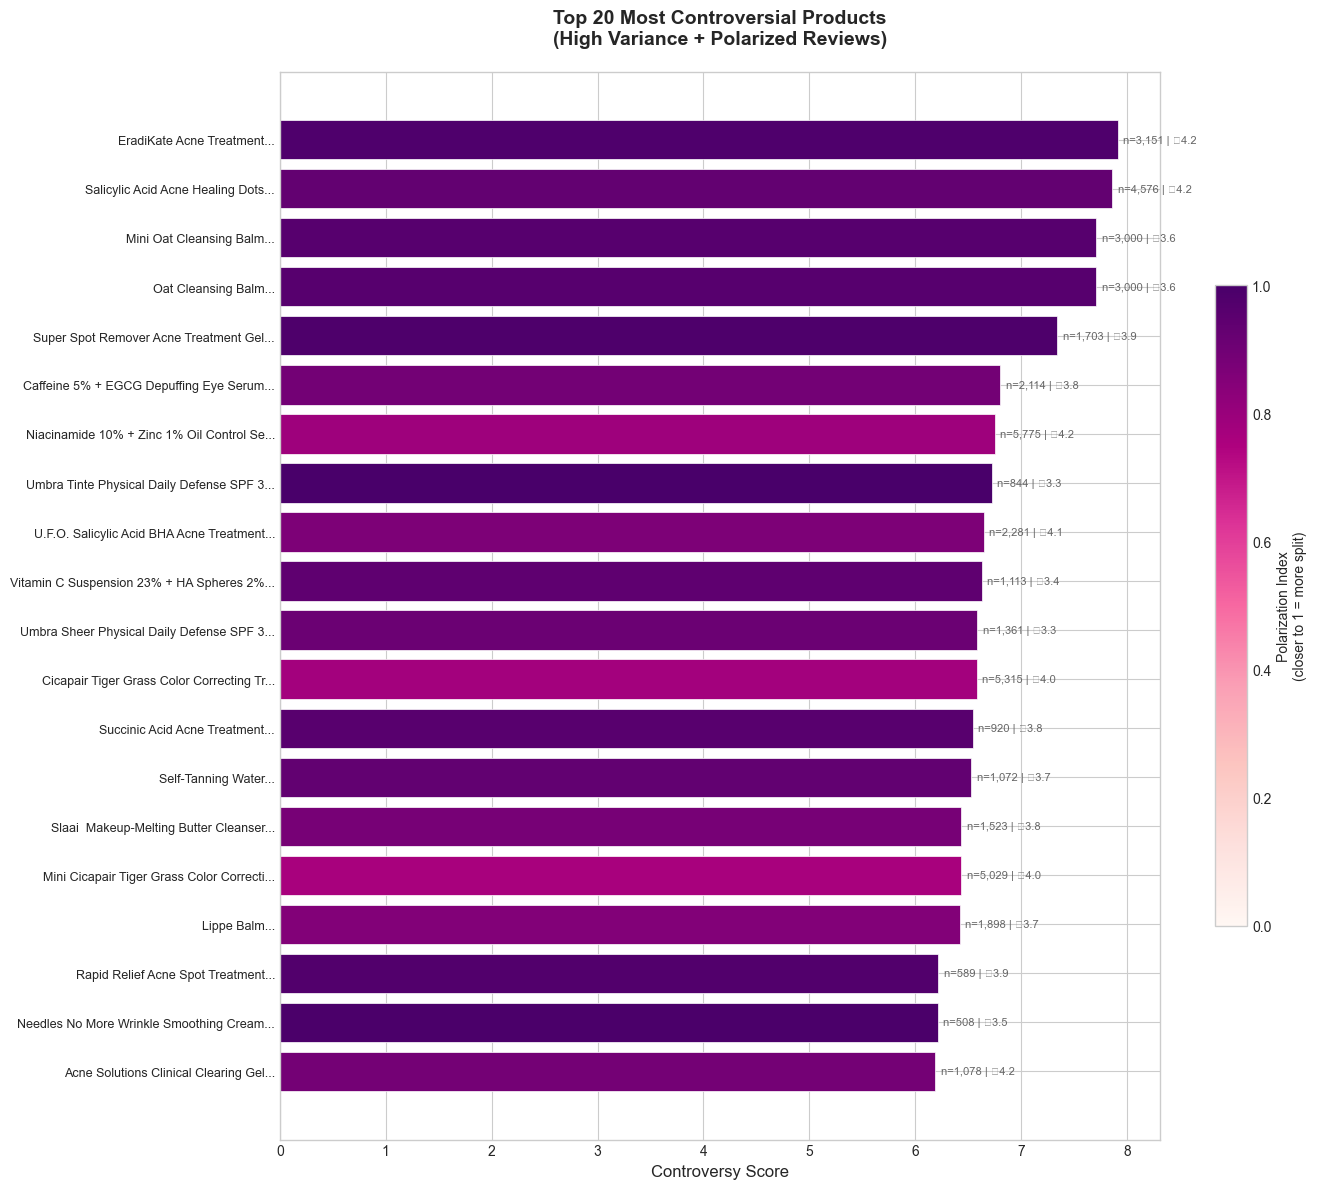


✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures/15_controversial_products.png


In [12]:
# CELL 17: Controversy score calculation
# Identify products with polarized reviews (high variance, significant volume)

print("Calculating controversy scores for products...")

# Calculate product-level statistics
product_stats = df.groupby(['product_id', 'product_name', 'brand_name']).agg({
    'sentiment_numeric': ['mean', 'std', 'count'],
    'sentiment_score': 'mean',
    'rating': ['mean', 'std'],
    'is_recommended': 'mean',
    'total_pos_feedback_count': 'sum',
    'total_neg_feedback_count': 'sum'
}).round(4)

product_stats.columns = ['sentiment_mean', 'sentiment_std', 'review_count',
                         'confidence_mean', 'rating_mean', 'rating_std',
                         'recommend_rate', 'total_pos_feedback', 'total_neg_feedback']
product_stats = product_stats.reset_index()

# Filter products with enough reviews for statistical significance
product_stats = product_stats[product_stats['review_count'] >= 50]

# Fill NaN in sentiment_std (happens when all reviews have same sentiment)
product_stats['sentiment_std'] = product_stats['sentiment_std'].fillna(0)

# Calculate controversy score
# Formula: (sentiment_std * log(review_count)) * (1 - abs(sentiment_mean))
# - Higher variance = more controversy
# - More reviews = more significant controversy
# - Sentiment mean close to 0 = truly polarized (not just consistently negative)

product_stats['controversy_score'] = (
    product_stats['sentiment_std'] * 
    np.log1p(product_stats['review_count']) * 
    (1 - np.abs(product_stats['sentiment_mean']))
)

# Also calculate a "polarization index"
# Percentage of strong opinions (very positive or very negative)
def calc_polarization(group):
    positive_pct = (group['sentiment'] == 'POSITIVE').mean()
    negative_pct = (group['sentiment'] == 'NEGATIVE').mean()
    # If close to 50/50, very polarized
    return 1 - abs(positive_pct - negative_pct)

polarization = df.groupby('product_id').apply(calc_polarization)
product_stats = product_stats.merge(
    polarization.reset_index().rename(columns={0: 'polarization_index'}),
    on='product_id'
)

# Final controversy score combines both metrics
product_stats['final_controversy'] = (
    product_stats['controversy_score'] * 0.5 + 
    product_stats['polarization_index'] * product_stats['review_count'].apply(np.log1p) * 0.5
)

# Sort by controversy
product_stats = product_stats.sort_values('final_controversy', ascending=False)

# Get top 20 most controversial products
top_controversial = product_stats.head(20).copy()

# Store for export
controversial_products_df = top_controversial.copy()

print("\nTOP 20 MOST CONTROVERSIAL PRODUCTS")
print("="*80)
for i, (idx, row) in enumerate(top_controversial.iterrows(), 1):
    print(f"\n{i}. {row['product_name'][:60]}...")
    print(f"   Brand: {row['brand_name']}")
    print(f"   Reviews: {row['review_count']:,.0f} | Rating: {row['rating_mean']:.2f} | Sentiment Std: {row['sentiment_std']:.3f}")
    print(f"   Polarization: {row['polarization_index']:.2f} | Controversy Score: {row['final_controversy']:.3f}")

# Create visualization
fig, ax = plt.subplots(figsize=(14, 12))

# Prepare data for plotting
plot_data = top_controversial.sort_values('final_controversy', ascending=True)
plot_data['short_name'] = plot_data['product_name'].str[:40] + '...'

# Color by polarization index
colors = plt.cm.RdPu(plot_data['polarization_index'])

bars = ax.barh(range(len(plot_data)), plot_data['final_controversy'], color=colors, edgecolor='white', linewidth=0.5)

ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data['short_name'], fontsize=9)
ax.set_xlabel('Controversy Score', fontsize=12)
ax.set_title('Top 20 Most Controversial Products\n(High Variance + Polarized Reviews)', 
             fontsize=14, fontweight='bold', pad=20)

# Add review count and rating labels
for i, (idx, row) in enumerate(plot_data.iterrows()):
    label = f"n={row['review_count']:,.0f} | ★{row['rating_mean']:.1f}"
    ax.text(row['final_controversy'] + 0.05, i, label, va='center', fontsize=8, color='#666')

# Add colorbar for polarization
sm = plt.cm.ScalarMappable(cmap='RdPu', norm=plt.Normalize(0, 1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
cbar.set_label('Polarization Index\n(closer to 1 = more split)', fontsize=10)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '15_controversial_products.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Saved: {FIGURES_DIR / '15_controversial_products.png'}")


Export Insights Summary

In [13]:
# CELL 18: Export comprehensive insights summary
# Combine all insights and export to CSV and text files

print("Exporting insights summary...")

# 1. Create comprehensive summary dataframe
# Combine negative features, TF-IDF, category variance, and controversial products

# Negative Features Summary
negative_summary = negative_features_df.copy()
negative_summary['insight_type'] = 'Negative Review Features'
negative_summary = negative_summary.rename(columns={'Category': 'item', 'Count': 'value', 'Percentage': 'percentage'})
negative_summary = negative_summary[['insight_type', 'item', 'value', 'percentage']]

# TF-IDF Summary
tfidf_5star_summary = top_5star_terms.copy()
tfidf_5star_summary['insight_type'] = 'TF-IDF: 5-Star Keywords'
tfidf_5star_summary = tfidf_5star_summary.rename(columns={'term': 'item', 'tfidf_5star': 'value'})
tfidf_5star_summary['percentage'] = None
tfidf_5star_summary = tfidf_5star_summary[['insight_type', 'item', 'value', 'percentage']]

tfidf_1star_summary = top_1star_terms.copy()
tfidf_1star_summary['insight_type'] = 'TF-IDF: 1-Star Keywords'
tfidf_1star_summary = tfidf_1star_summary.rename(columns={'term': 'item', 'tfidf_1star': 'value'})
tfidf_1star_summary['percentage'] = None
tfidf_1star_summary = tfidf_1star_summary[['insight_type', 'item', 'value', 'percentage']]

# Category Variance Summary
category_summary = category_variance_df.head(15).copy()
category_summary['insight_type'] = 'Category Sentiment Variance'
category_summary = category_summary.rename(columns={'product_category': 'item', 'sentiment_std': 'value'})
category_summary['percentage'] = category_summary['review_count']
category_summary = category_summary[['insight_type', 'item', 'value', 'percentage']]

# Controversial Products Summary
controversial_summary = controversial_products_df.head(20).copy()
controversial_summary['insight_type'] = 'Controversial Products'
controversial_summary['item'] = controversial_summary['product_name'].str[:60] + ' (' + controversial_summary['brand_name'] + ')'
controversial_summary = controversial_summary.rename(columns={'final_controversy': 'value'})
controversial_summary['percentage'] = controversial_summary['review_count']
controversial_summary = controversial_summary[['insight_type', 'item', 'value', 'percentage']]

# Combine all summaries
insights_summary = pd.concat([
    negative_summary,
    tfidf_5star_summary,
    tfidf_1star_summary,
    category_summary,
    controversial_summary
], ignore_index=True)

# Save to CSV
insights_summary.to_csv(REPORTS_DIR / 'sentiment_insights_summary.csv', index=False)
print(f"✓ Saved: {REPORTS_DIR / 'sentiment_insights_summary.csv'}")

# 2. Also save detailed CSVs for each analysis
negative_features_df.to_csv(REPORTS_DIR / 'negative_features_detailed.csv', index=False)
tfidf_comparison_df.to_csv(REPORTS_DIR / 'tfidf_comparison_detailed.csv', index=False)
category_variance_df.to_csv(REPORTS_DIR / 'category_variance_detailed.csv', index=False)
controversial_products_df.to_csv(REPORTS_DIR / 'controversial_products_detailed.csv', index=False)

print(f"✓ Saved detailed CSVs to {REPORTS_DIR}")

# 3. Create text summary of key findings
key_findings = f"""
{'='*70}
SEPHORA SENTIMENT ANALYSIS - KEY FINDINGS REPORT
{'='*70}
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASET OVERVIEW
----------------
Total Reviews Analyzed: {len(df):,}
Positive Reviews: {(df['sentiment'] == 'POSITIVE').sum():,} ({(df['sentiment'] == 'POSITIVE').mean()*100:.1f}%)
Negative Reviews: {(df['sentiment'] == 'NEGATIVE').sum():,} ({(df['sentiment'] == 'NEGATIVE').mean()*100:.1f}%)


{'='*70}
1. TOP COMPLAINT CATEGORIES IN NEGATIVE REVIEWS
{'='*70}
"""

for i, (idx, row) in enumerate(negative_features_df.nlargest(10, 'Count').iterrows(), 1):
    key_findings += f"   {i:2}. {row['Category']:25s}: {row['Count']:,} reviews ({row['Percentage']:.1f}%)\n"

key_findings += f"""

{'='*70}
2. VOCABULARY DIFFERENCES: 5-STAR vs 1-STAR REVIEWS
{'='*70}

Words UNIQUE to 5-STAR reviews (positive sentiment indicators):
"""
for i, (idx, row) in enumerate(top_5star_terms.head(10).iterrows(), 1):
    key_findings += f"   {i:2}. {row['term']}\n"

key_findings += """
Words UNIQUE to 1-STAR reviews (negative sentiment indicators):
"""
for i, (idx, row) in enumerate(top_1star_terms.head(10).iterrows(), 1):
    key_findings += f"   {i:2}. {row['term']}\n"

key_findings += f"""

{'='*70}
3. MOST POLARIZING PRODUCT CATEGORIES (by sentiment variance)
{'='*70}
"""
for i, (idx, row) in enumerate(category_variance_df.head(10).iterrows(), 1):
    key_findings += f"   {i:2}. {row['product_category']:25s}: std={row['sentiment_std']:.3f} (n={row['review_count']:,.0f})\n"

key_findings += f"""

{'='*70}
4. TOP 10 MOST CONTROVERSIAL PRODUCTS
{'='*70}
"""
for i, (idx, row) in enumerate(controversial_products_df.head(10).iterrows(), 1):
    key_findings += f"""
   {i}. {row['product_name'][:55]}
      Brand: {row['brand_name']}
      Reviews: {row['review_count']:,.0f} | Rating: {row['rating_mean']:.2f}★ | Polarization: {row['polarization_index']:.2f}
"""

key_findings += f"""

{'='*70}
5. ACTIONABLE INSIGHTS
{'='*70}

Based on the analysis, here are key recommendations:

FOR PRODUCT DEVELOPMENT:
• Address top complaint: "{negative_features_df.nlargest(1, 'Count')['Category'].values[0]}" 
  ({negative_features_df.nlargest(1, 'Count')['Percentage'].values[0]:.1f}% of negative reviews)
• Focus quality improvement on high-variance categories like 
  "{category_variance_df.head(1)['product_category'].values[0]}"

FOR MARKETING:
• Emphasize positive attributes like: {', '.join(top_5star_terms.head(5)['term'].tolist())}
• Address concerns around: {', '.join(top_1star_terms.head(5)['term'].tolist())}

FOR CUSTOMER SERVICE:
• Monitor controversial products for quality issues
• Proactively address common complaints about texture, reactions, and effectiveness

{'='*70}
END OF REPORT
{'='*70}
"""

# Save text report
with open(REPORTS_DIR / 'key_findings.txt', 'w') as f:
    f.write(key_findings)

print(f"✓ Saved: {REPORTS_DIR / 'key_findings.txt'}")

# Print summary
print("\n" + "="*60)
print("EXPORT COMPLETE")
print("="*60)
print(f"\nFiles saved to {REPORTS_DIR}:")
print(f"  • sentiment_insights_summary.csv")
print(f"  • negative_features_detailed.csv")
print(f"  • tfidf_comparison_detailed.csv")
print(f"  • category_variance_detailed.csv")
print(f"  • controversial_products_detailed.csv")
print(f"  • key_findings.txt")

print(f"\nFigures saved to {FIGURES_DIR}:")
print(f"  • 12_negative_features.png")
print(f"  • 13_tfidf_comparison.png")
print(f"  • 14_category_variance.png")
print(f"  • 15_controversial_products.png")

# Display the key findings
print("\n" + key_findings)


Exporting insights summary...
✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/reports/sentiment_insights_summary.csv
✓ Saved detailed CSVs to /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/reports
✓ Saved: /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/reports/key_findings.txt

EXPORT COMPLETE

Files saved to /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/reports:
  • sentiment_insights_summary.csv
  • negative_features_detailed.csv
  • tfidf_comparison_detailed.csv
  • category_variance_detailed.csv
  • controversial_products_detailed.csv
  • key_findings.txt

Figures saved to /Users/nischalanagisetty/Documents/Data-Analyst-Portfolio/sephora-beauty-analytics/outputs/figures:
  • 12_negative_features.png
  • 13_tfidf_comparison.png
  • 14_category_variance.png
  • 15_controversial_products.png


SEPHORA S